In [1]:
from pathlib import Path
from os.path import expanduser
from os import path
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os

In [2]:
max_dataset_size = 2500000;
waveform_length = 72;
nb_of_elements = 150000;
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nb_of_datasets = 45;
snr_from = 20;
snr_to = 100;
max_shift = 0;
use_horizontal_flip = False;
use_vertical_flip = False;
filter_type = 'high';
sampling_rate = 24000;
passband = np.array([100], dtype=int);
order = 1;



In [3]:
root_folder = os.path.dirname(os.getcwd())
path_to_recordings = path.join(root_folder,'data/synthesized');
path_to_ground_truth_data = path.join(root_folder,'data/synthesized');
path_to_train_data = path.join(root_folder,'data/train_data_re_id.npy');
path_to_train_labels = path.join(root_folder,'data/train_labels_re_id.npy');
sys.path.append(root_folder)
from custom_resnet import CustomResnet as cnn
transform_list =[cnn.FilterSignalUsingButtersWorth(filter_type, sampling_rate, passband, order), cnn.OptimizedZScoreNormalizaton()];



In [4]:

# counts each class
classes_per_recording = np.zeros((nb_of_datasets), dtype='int')
for i in range(0 , nb_of_datasets):
    single_recording_ground_truth = path.join(path_to_ground_truth_data, 'gt_' + str(i + 1) + '.npy');
    gt_data = np.load(single_recording_ground_truth);
    classes_per_recording[i] = np.unique(gt_data[1,:]).size;
    print(np.unique(gt_data[1,:]))
    print(np.min(gt_data))
print(classes_per_recording)

# class counter to concatenate classes together from different recordings
class_counter = np.zeros((nb_of_datasets, 1), dtype='int');
class_counter[0] = 0;
for i in range(1, nb_of_datasets):
    class_counter[i] = class_counter[i-1] + classes_per_recording[i - 1] - 1; 
print(class_counter)



[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
0.0
[0. 1. 2. 3. 4.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
0.0
[0. 1. 2.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
0.0
[0. 1. 2. 3.]
0.0
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
0.0
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
0.0
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
0.0
[0. 1. 2. 

In [5]:
# couts sample count for each class
nb_of_classes = int(np.sum(classes_per_recording - 1) + 1);


In [6]:
print(classes_per_recording)
print(class_counter)

[17 20 13  5 16 12 18  3 20 21 21 21 11  4 10  9 10  8 19 15  5  7 18  7
 17 14  6 15  4  6 12 11  5  9 13 19 11 14  3  8 16 10 17 14  9]
[[  0]
 [ 16]
 [ 35]
 [ 47]
 [ 51]
 [ 66]
 [ 77]
 [ 94]
 [ 96]
 [115]
 [135]
 [155]
 [175]
 [185]
 [188]
 [197]
 [205]
 [214]
 [221]
 [239]
 [253]
 [257]
 [263]
 [280]
 [286]
 [302]
 [315]
 [320]
 [334]
 [337]
 [342]
 [353]
 [363]
 [367]
 [375]
 [387]
 [405]
 [415]
 [428]
 [430]
 [437]
 [452]
 [461]
 [477]
 [490]]


In [7]:
16+19+12

47

In [8]:
max_dataset_size = max_dataset_size + nb_of_classes - max_dataset_size % nb_of_classes;
samples_per_class = max_dataset_size // nb_of_classes;
print(samples_per_class)
print(max_dataset_size / nb_of_classes)
print(max_dataset_size)


5011
5011.0
2500489


In [9]:
unique_list = [];
dataset = np.array([])
labels = np.array([], dtype = "int")
# adds single unit activity data
for i in range(0, nb_of_datasets):
    added_sample_counter = np.zeros((classes_per_recording[i] - 1));
    data_iter_counter = 0;
    total_nb_of_samples = int((classes_per_recording[i] - 1) * samples_per_class);
    temp_spikes = np.zeros((total_nb_of_samples, 1, waveform_length));
    temp_labels = np.zeros((1, total_nb_of_samples), dtype='int');
    print(dataset.shape)
    # generates augmentations until there are same sized samples for each class
    while (data_iter_counter < total_nb_of_samples):
        single_recording_path = path.join(path_to_recordings, 'data_' + str(i + 1) + '.npy');
        single_recording_ground_truth = path.join(path_to_ground_truth_data, 'gt_' + str(i + 1) + '.npy');
        dataset_spikes = cnn.GenerateDataset(single_recording_path, single_recording_ground_truth, waveform_length, 600, snr_from, snr_to, max_shift, use_horizontal_flip, use_vertical_flip, transform_list);
        # adds to temp variable to add to real dataset afterwards
        for j, (data, target) in enumerate(dataset_spikes):
            neuron_index = target.item();
            if(neuron_index > 0 and added_sample_counter[neuron_index - 1] < samples_per_class):
                spike_waveform =  (data.numpy());
                temp_spikes[data_iter_counter, :] = spike_waveform;
                class_index = class_counter[i] + neuron_index;
                # changes class index
                temp_labels[0, data_iter_counter] = class_index;
                added_sample_counter[neuron_index - 1] = added_sample_counter[neuron_index - 1] + 1;
                data_iter_counter = data_iter_counter + 1;
    unique_list.append(np.unique(temp_labels));
    print(added_sample_counter)
    if (dataset.size == 0):
        dataset = temp_spikes;
    else:
        dataset = np.concatenate((dataset, temp_spikes), axis=0)  
        
    if (labels.size == 0): 
        labels = temp_labels;
    else:
        labels = np.concatenate((labels, temp_labels), axis=1)            

    
# adds multi unit activity data
data_iter_counter = 0;
total_nb_of_samples = int(samples_per_class);
temp_spikes = np.zeros((total_nb_of_samples, 1, waveform_length));
temp_labels = np.zeros((1, total_nb_of_samples), dtype='int');
while (data_iter_counter < total_nb_of_samples):
    for i in range(0, nb_of_datasets):
        single_recording_path = path.join(path_to_recordings, 'data_' + str(i + 1) + '.npy');
        single_recording_ground_truth = path.join(path_to_ground_truth_data, 'gt_' + str(i + 1) + '.npy');
        dataset_spikes = cnn.GenerateDataset(single_recording_path, single_recording_ground_truth, waveform_length, 600, snr_from, snr_to, max_shift, use_horizontal_flip, use_vertical_flip, transform_list);
        # adds to temp variable to add to real dataset afterwards
        for j, (data, target) in enumerate(dataset_spikes):
            neuron_index = target.item();
            if(neuron_index == 0 and data_iter_counter < total_nb_of_samples):
                spike_waveform =  (data.numpy());
                temp_spikes[data_iter_counter, :] = spike_waveform;
                class_index = neuron_index;
                # changes class index
                temp_labels[0, data_iter_counter] = class_index;
                data_iter_counter = data_iter_counter + 1;
                
        
unique_list.append(np.unique(temp_labels));
if (dataset.size == 0):
    dataset = temp_spikes;
else:
    dataset = np.concatenate((dataset, temp_spikes), axis=0)  
        
if (labels.size == 0): 
    labels = temp_labels;
else:
    labels = np.concatenate((labels, temp_labels), axis=1)            

(0,)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  27.189515173281638
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55e80>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)


/home/vtpc/Documents/Alvils/spike-sorting/custom_resnet/CustomResnet.py:293: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  temp = temp.new_tensor(data);


dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  84.83909138175984
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55cf8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  75.4742479594016
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  65.77113879046517
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55e10>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  46.464826299987486
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55f28>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  68.6015221618706
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55d30>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  12008
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  52.66462320039743
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc55cf8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9c1cf8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  45.47341764740294
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9c1dd8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int3

dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  70.64605256706112
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9cb278>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  56.7320679193426
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9cb278>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  65.2274642250966
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9cb278>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  93.41984410945969
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9cb278>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  76.85685399851188
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d30b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  45.38927860707249
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3128>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  72.28514692582056
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d30b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  76.11282447361585
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3128>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  59.126354033422
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d30b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  12778
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.69988408363432
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3128>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3128>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  82.27303047382873
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d30b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d30f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  91.01433457462615
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d30f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  66.99926024849694
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9273
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  5125
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.176775502586736
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  5125
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  25.173709679830313
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  70.4324377824383
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  72.58543669879668
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  47.332654455770694
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  50.05550184391063
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  82.83420632014898
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  41.30309323574828
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  11756
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  41.761713361047164
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(11, dtype=torch.int32)
dataset len:  10183
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  40.844309335469035
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3e48>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(11, dtype=torch.int32)
dataset len:  10183
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int

dataset len:  10183
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  39.220163876359315
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3ef0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(11, dtype=torch.int32)
dataset len:  10183
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  65.54205688518992
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3ef0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  10183
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  31.829395191587874
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d11d0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(11, dtype=torch.int32)
dataset len:  10183
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.14964815337039
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d11d0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d11d0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13995
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  75.4029102257751
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d11d0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13995
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

dataset len:  13995
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  52.455897622922485
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ba8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13995
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  72.47054155883235
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ba8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(2, dtype=torch.int32)
dataset len:  3489
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  29.305150008322506
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(2, dtype=torch.int32)
dataset len:  3489
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(2, dtype=torch.int32)
dataset len:  3489
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  47.38143634726018
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(2, dtype=torch.int32)
dataset len:  3489
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  35.15267210735403
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ef0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  37.54224851324664
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ef0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  26.483077742138146
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  56.69624112963956
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  87.997920387759
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  100.84404629193573
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  88.47755755172939
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  50.351244774248464
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  28.529802115675857
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(19, dtype=torch.int32)
dataset len:  15650
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  81.02025520643161
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ba8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ef0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  65.56202464549125
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d1ef0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int3

dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  98.22142372837868
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  68.83759061335293
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.122401999632494
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  25.155428892607855
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obj

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  63.725078282781816
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int

dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  43.30209765812568
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.460176081431115
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  63.78764146414993
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  61.15384198466909
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  50.839747298601736
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2860>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  42.63235494934788
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2860>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25f8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  53.26031318909287
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29e8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int3

dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  50.11459184448771
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29e8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  37.25428666050881
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29e8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  87.03875416579369
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  35.53762482993482
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  87.2028817260001
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  13485
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  90.169512806148
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object a

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  89.14159991216836
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.36770376899656
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  35.22583771881364
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  26.150070151313834
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2940>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  61.611648733122514
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2940>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2940>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  7790
[5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011.]
(927035, 1, 72)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.93505851427118
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2470>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(3, dtype=torch.int32)
dataset len:  4499
========== 1 generation ==========
temp_dataset_len:  0
shift_from: 

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29e8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(3, dtype=torch.int32)
dataset len:  4499
[5011. 5011. 5011.]
(942068, 1, 72)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  66.19321806304453
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  9682
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexe

dataset len:  9682
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.52046204464942
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  9682
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  49.164046023626014
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  59.6690151338658
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  35.94652086019893
flip_data_horz:  0
[ 0.9

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  90.47585841572331
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  90.66658688092559
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  47.39064420817274
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  52.53081011963791
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  7552
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

(1027255, 1, 72)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.1024010185098
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  9092
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  49.895137767366165
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 

dataset len:  9092
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  78.56927171468334
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  9092
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  68.81871752946618
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object a

dataset len:  9092
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  46.64682474352884
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  9092
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  34.227450046985254
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7004
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  96.5330514346649
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7004
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  38.226314914894004
flip_data_horz:  0
[ 0.

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7004
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  96.93741910924338
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7004
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2940>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7004
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  57.27909441541083
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2940>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7004
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

dataset len:  13803
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  52.33730540126443
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2630>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  13803
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  26.70217470475477
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2630>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  13803
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  69.73093989570029
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  13803
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  20.083116025276073
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  54.84926215067182
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int3

dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  98.68975583646481
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  83.81866659684404
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  41.564577916510494
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  77.42374145246731
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  61.939871891233814
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  11186
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  77.46473352238313
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  52.37693099132793
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  91.51830000187107
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  34.57130073323767
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  45.101624218632345
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4289
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


dataset len:  7098
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  95.57080199504296
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(6, dtype=torch.int32)
dataset len:  7098
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  49.836628236377784
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  81.08375016027937
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  97.74141465695602
flip_data_horz:  0


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  65.1094042467139
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  77.69063051342084
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  96.5808305370243
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  25.205140326169634
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2630>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  67.24081346974604
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2630>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  65.83915251373203
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(17, dtype=torch.int32)
dataset len:  13371
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  37.57440077153343
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(6, dtype=torch.int32)
dataset len:  6298
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  61.87486291045543
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2940>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(6, dtype=torch.int32)
dataset len:  6298
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

dataset len:  14109
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.615301924049334
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  14109
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.88859651813412
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  14109
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.10082609500801
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  14109
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  62.607844378013105
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  12310
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  57.28495984173541
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  12310
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int3

dataset len:  12310
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  46.23263699486399
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  12310
[5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011.
 5011.]
(1578465, 1, 72)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  84.8654197375425
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButt

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  6528
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  39.141704352870384
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  6528
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  30.34753152115684
flip_data_horz:  0
[ 0

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  6528
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  33.956443054651395
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2cc0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  6528
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b00>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  6528
[5011. 5011. 5011. 5011. 5011.]
(1603520, 1, 72)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  66.66029642502983
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  12077
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step: 

dataset len:  12077
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.766531148070115
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  12077
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  59.82873252245594
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  12077
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.054366023460254
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(14, dtype=torch.int32)
dataset len:  12077
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  66.17688159978849
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(3, dtype=torch.int32)
dataset len:  4174
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  24.903840288102607
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(3, dtype=torch.int32)
dataset len:  4174
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  33.12637033358211
flip_data_horz:  0
[ 0

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  5208
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  94.91693313763287
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  5208
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c50>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  5208
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  44.952878159919415
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c50>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  5208
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


dataset len:  8222
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  63.71769593215203
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(11, dtype=torch.int32)
dataset len:  8222
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.91471502931577
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9075
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  53.426077447669186
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9075
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.54457081360336
flip_data_horz:  0
[

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9075
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  75.1876208283777
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9075
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  61.38016873191705
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  100.75033428950505
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  43.39642729031164
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ac8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  61.89455615754104
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b38>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b38>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  68.49815124469022
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b38>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  41.41289942757367
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2d68>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(4, dtype=torch.int32)
dataset len:  4166
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  80.29366909564584
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ba8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  72.47411735948553
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]


dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  52.222861685052095
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  71.25357180749252
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c88>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  77.84116994811251
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  100.62298807591672
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2cc0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  76.51223266792822
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.6826502583111
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at

dataset len:  6848
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  78.81856464026951
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e25c0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6848
[5011. 5011. 5011. 5011. 5011. 5011. 5011. 5011.]
(1879125, 1, 72)
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  38.58822642038296
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9478
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  78.4195110769396
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2cc0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9478
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  57.32274316633568
flip_data_horz:  0
[ 0

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9478
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  88.8757739238511
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9478
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9478
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  91.97279244603388
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(12, dtype=torch.int32)
dataset len:  9478
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  99.69661294331272
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2898>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  20.684496353855447
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2898>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  33.17000400020993
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2898>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  75.31587294316537
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2898>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  84.06554177543154
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  78.12559834184376
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  89.97086039531274
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  48.570063864367825
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  87.7183735123494
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(18, dtype=torch.int32)
dataset len:  12374
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  88.91145293646778
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9952
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  73.79464857347223
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9952
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9952
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  62.2113069467672
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(10, dtype=torch.int32)
dataset len:  9952
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


dataset len:  11147
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  97.9528715412319
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  11147
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  99.03416828380963
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  11147
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  53.589473559976234
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  11147
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  84.98488492455883
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(2, dtype=torch.int32)
dataset len:  4717
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  26.698344526064677
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2a90>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(2, dtype=torch.int32)
dataset len:  4717
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)


dataset len:  7354
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  67.40968882356687
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(7, dtype=torch.int32)
dataset len:  7354
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  70.66894622764579
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object a

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  13344
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  81.10023281378686
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  13344
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  97.9457479864383
flip_data_horz:  0
[

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  13344
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  28.743690566384817
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20f0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(15, dtype=torch.int32)
dataset len:  13344
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int

dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  28.938450218286345
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  20.22246815539306
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ba8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  35.690380849338794
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  33.64881442412745
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]

========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  53.50822580621217
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2ba8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  69.83723093981311
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]


dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  62.62171834532355
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e29b0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  37.43337411847417
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b70>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object a

========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  53.87870220248628
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  97.61629908429516
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2978>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]


========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  46.38187818868469
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e20b8>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(9, dtype=torch.int32)
dataset len:  6744
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  92.8245441215929
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2908>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
t

[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2710>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  71.4432997440876
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2710>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  94.77037832498145
flip_data_horz:  0
[

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  78.62840939963766
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int3

dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  72.51781661519134
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  55.76054072185496
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.863174416166885
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2cc0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  51.12083048592879
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2cc0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton obje

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c50>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  10570
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  83.1178706105562
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2c50>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  10570
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32

dataset len:  10570
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  62.40381270843081
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7fab6b7e7f98>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  10570
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  64.9204088691382
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc3d550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object

dataset len:  10570
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  62.78864630959671
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc3cc18>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(13, dtype=torch.int32)
dataset len:  10570
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  54.05005954001038
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadcc3cc18>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3c18>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  99.39066731636404
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3da0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  79.58318974116038
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3fd0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3550>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  32.68821024964013
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3400>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3080>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  63.3249086343098
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3da0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
sn

[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d36a0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  92.75680466744419
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d36a0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(8, dtype=torch.int32)
dataset len:  6663
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
s

dataset len:  15146
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  90.75494969987476
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9d3c18>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(20, dtype=torch.int32)
dataset len:  14975
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  31.77884261981011
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2b38>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton objec

dataset len:  12310
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  58.44403911837122
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(5, dtype=torch.int32)
dataset len:  6528
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  56.82557560958745
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e2be0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object 

========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  67.67872389640519
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e26a0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>]
tensor(16, dtype=torch.int32)
dataset len:  10867
========== 1 generation ==========
temp_dataset_len:  0
shift_from:  0
shift_to:  1
shift_step:  1
shift_indexes:  tensor([0], dtype=torch.int32)
snr_ratio:  91.06344078573996
flip_data_horz:  0
[ 0.98707844 -0.98707844] [ 1.         -0.97415687]
[<custom_resnet.CustomResnet.Awgn object at 0x7faadc9e26a0>, <custom_resnet.CustomResnet.FilterSignalUsingButtersWorth object at 0x7faafcb0f160>, <custom_resnet.CustomResnet.OptimizedZScoreNormalizaton object at 0x7faafcb0f080>

In [10]:
for i in range(0, len(unique_list)):
    print(unique_list[i])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44 45 46 47]
[48 49 50 51]
[52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
[67 68 69 70 71 72 73 74 75 76 77]
[78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
[95 96]
[ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115]
[116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135]
[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155]
[156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175]
[176 177 178 179 180 181 182 183 184 185]
[186 187 188]
[189 190 191 192 193 194 195 196 197]
[198 199 200 201 202 203 204 205]
[206 207 208 209 210 211 212 213 214]
[215 216 217 218 219 220 221]
[222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239]
[240 241 242 243 244 245 246 247 248 249 250 251 252 253]
[254 255 256 257]
[258 259 260 261 262 2

In [11]:
class_sample_count = np.unique(labels, return_counts=True)[1]
class_sample_count

array([5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011, 5011,
       5011, 5011, 5011, 5011, 5011, 5011, 5011, 50

In [16]:
print(dataset.shape)
print(labels.shape)

(2500489, 1, 72)
(1, 2500489)


/home/vtpc/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


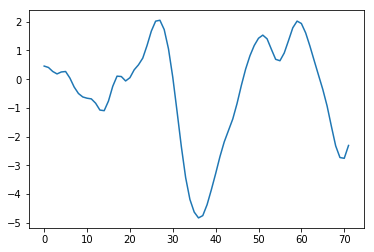

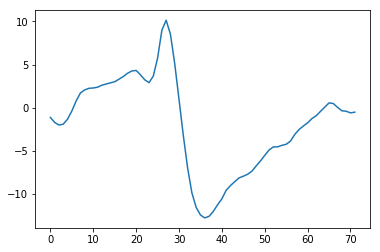

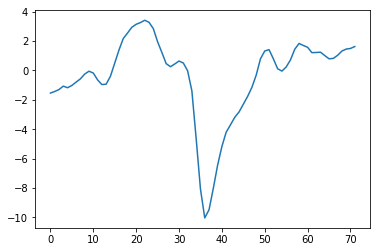

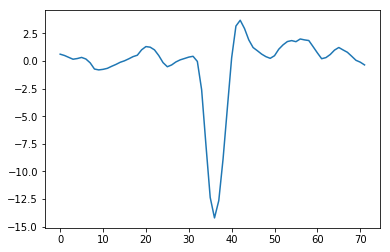

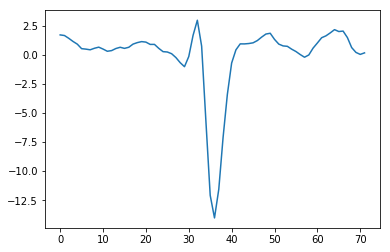

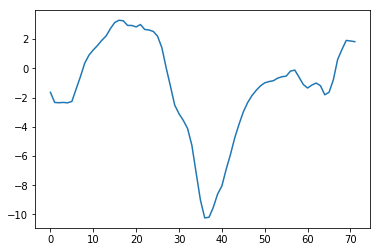

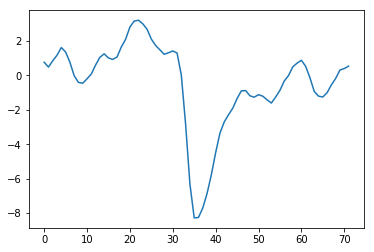

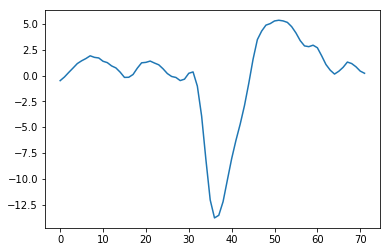

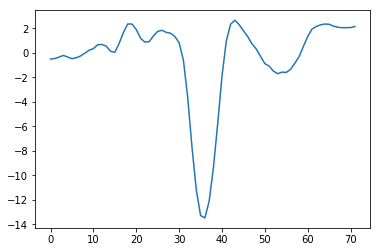

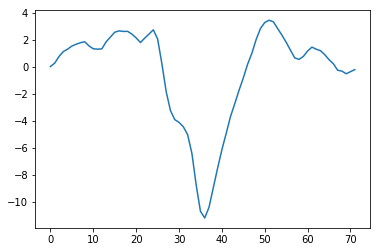

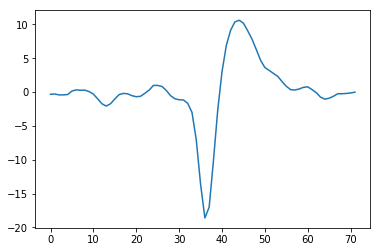

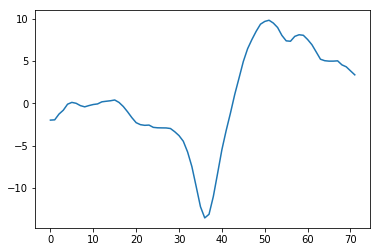

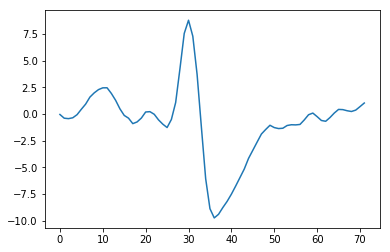

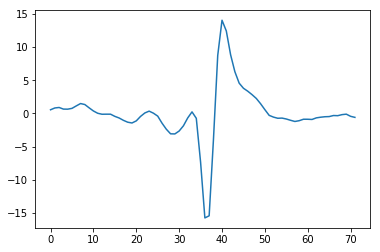

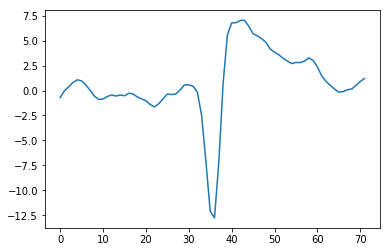

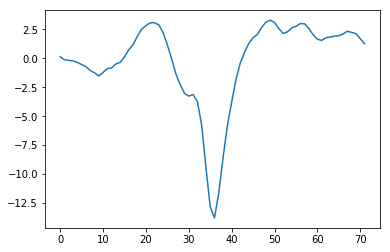

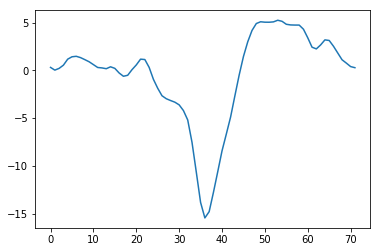

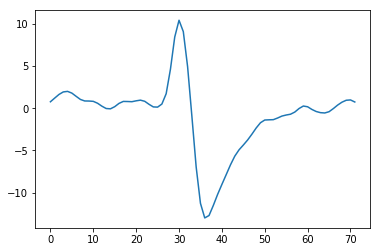

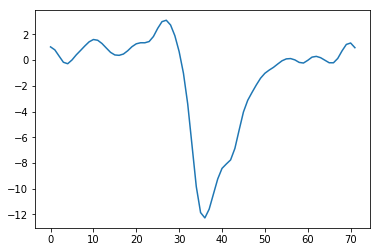

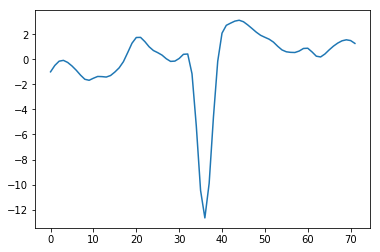

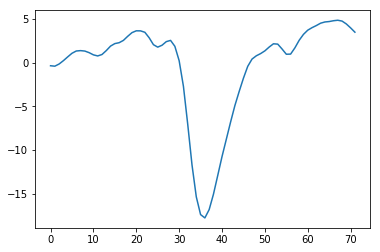

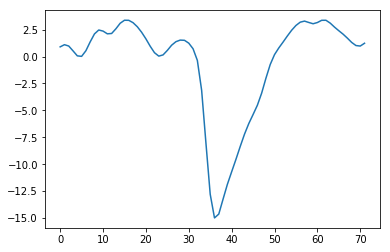

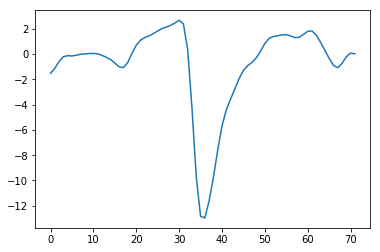

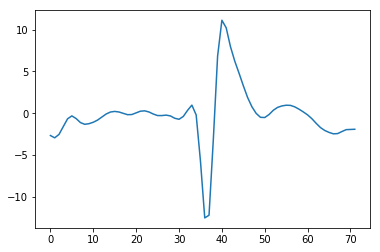

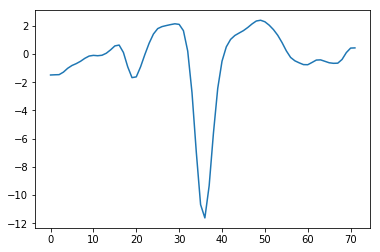

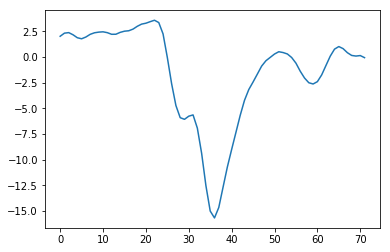

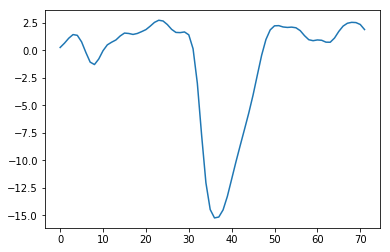

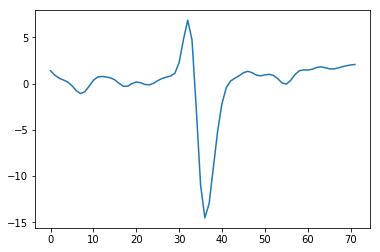

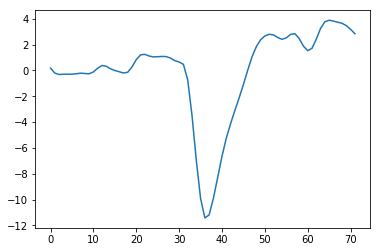

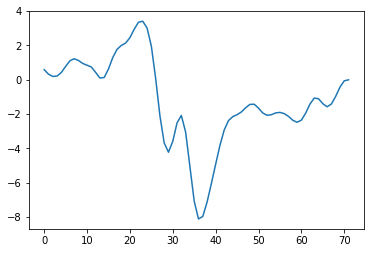

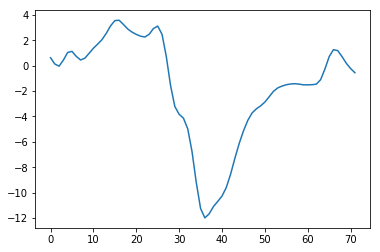

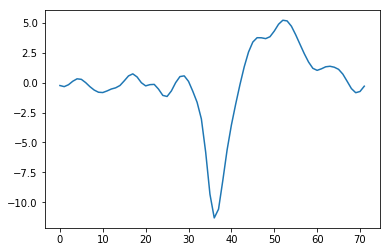

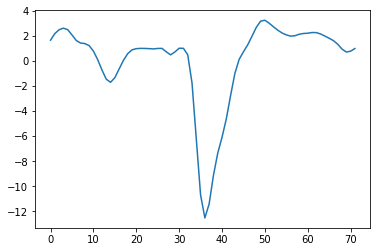

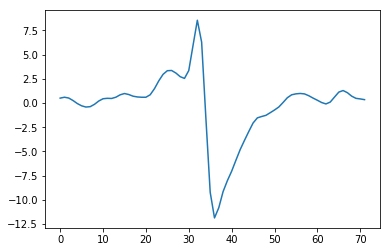

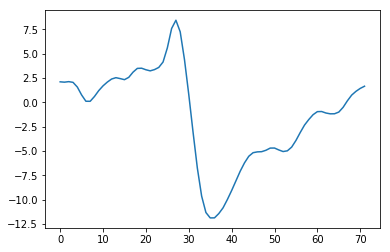

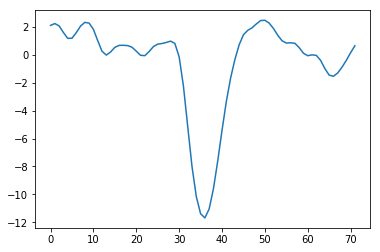

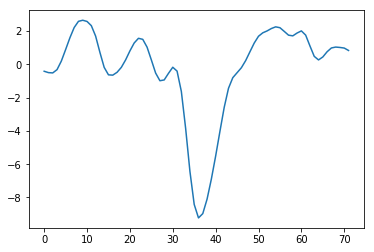

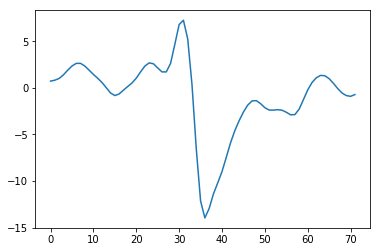

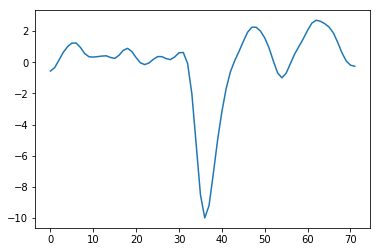

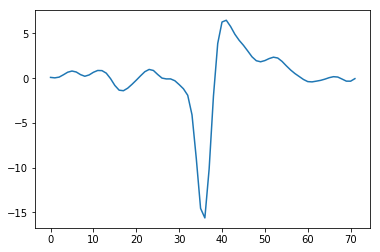

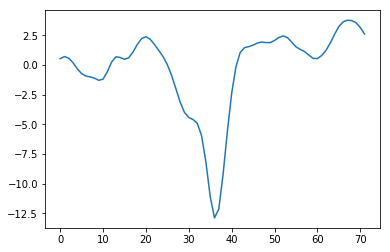

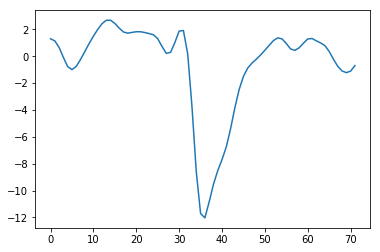

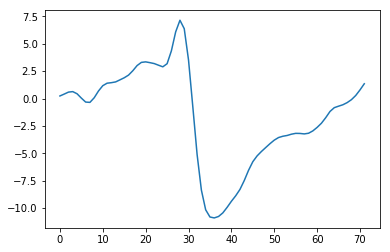

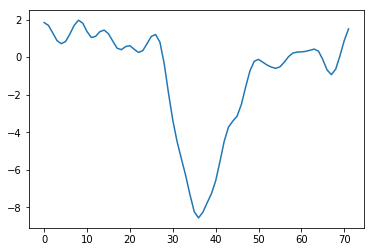

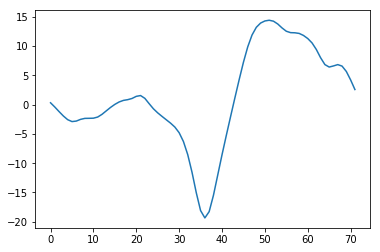

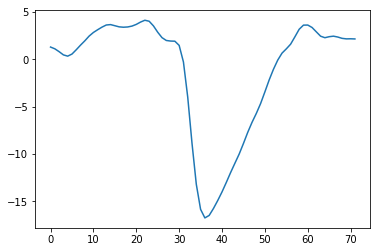

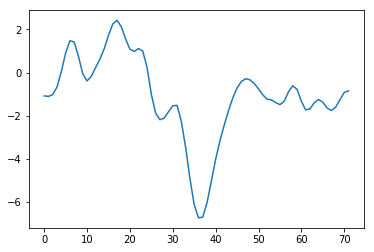

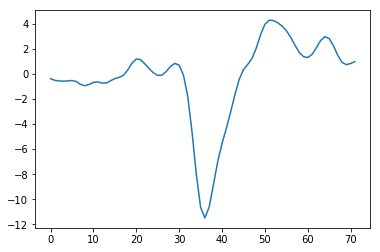

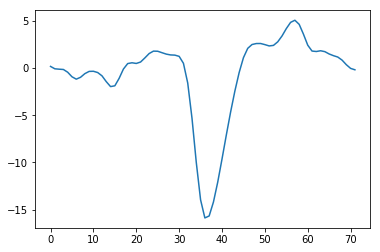

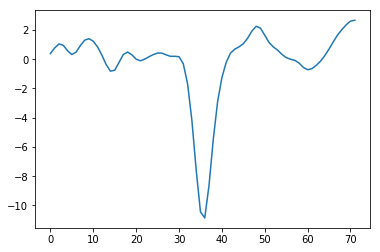

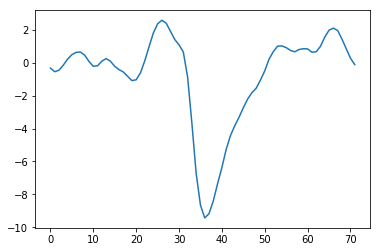

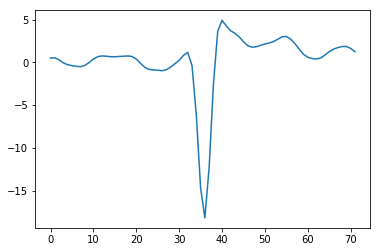

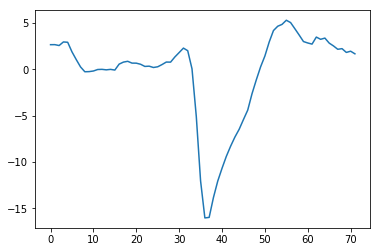

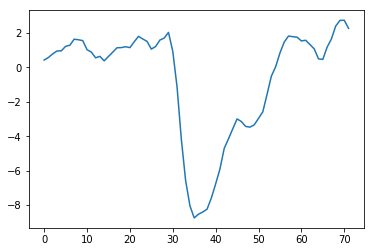

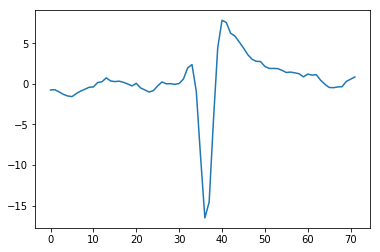

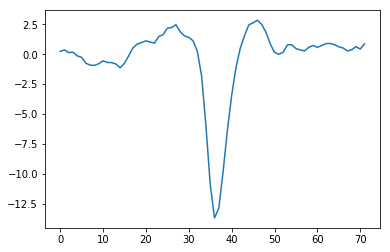

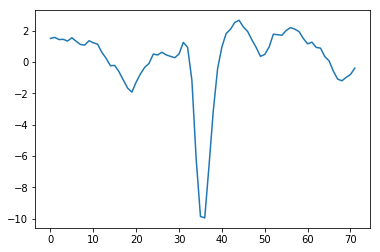

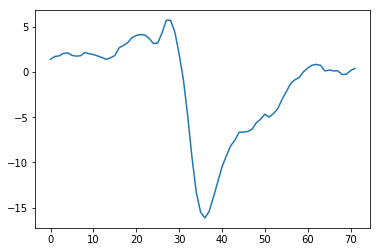

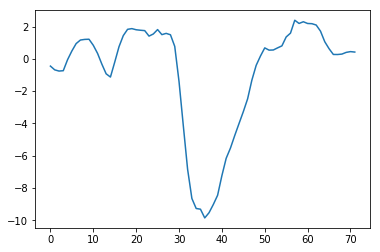

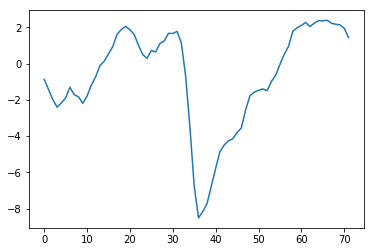

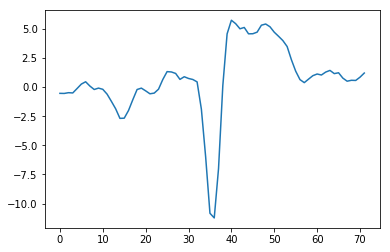

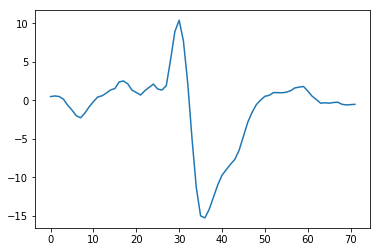

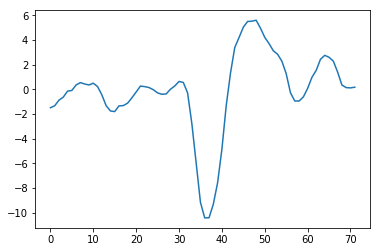

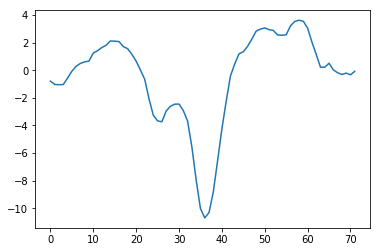

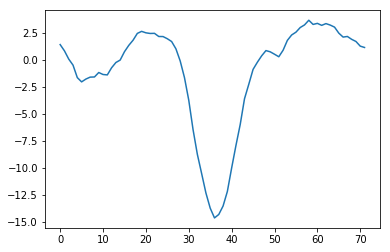

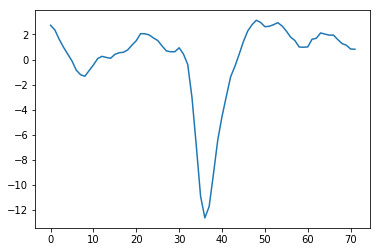

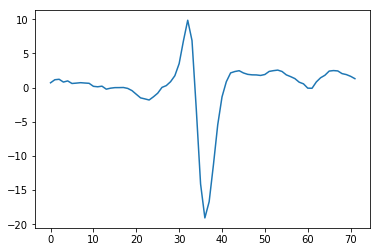

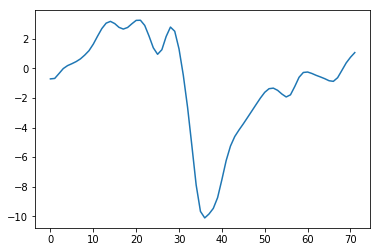

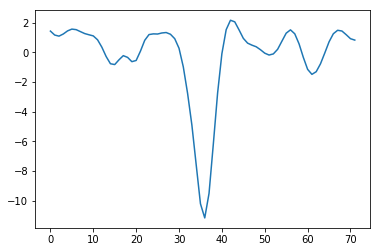

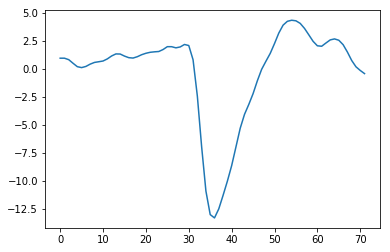

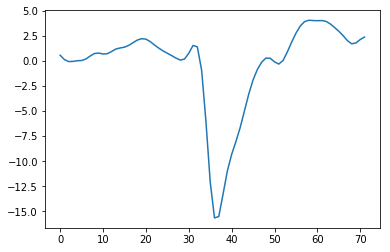

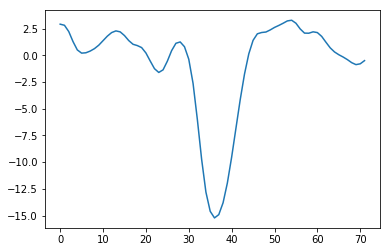

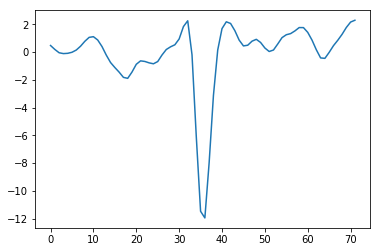

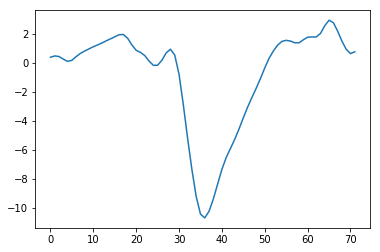

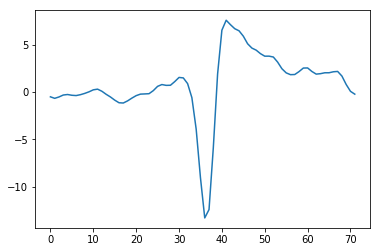

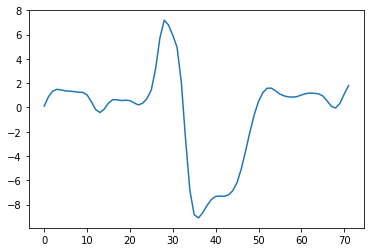

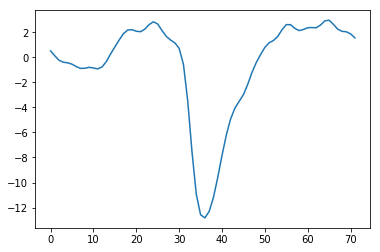

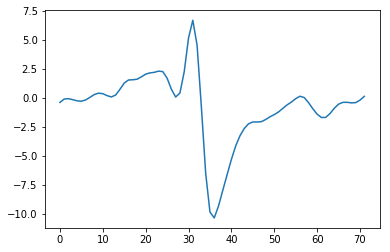

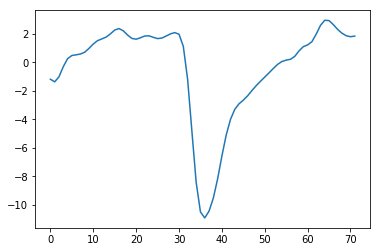

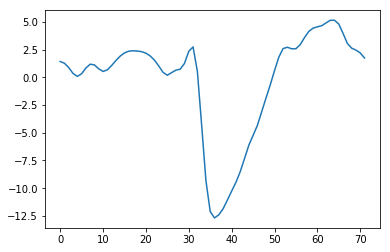

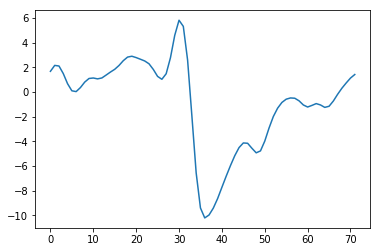

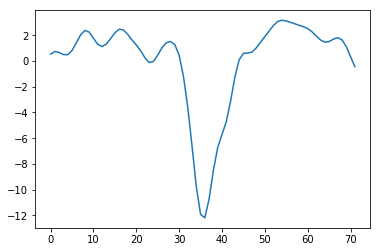

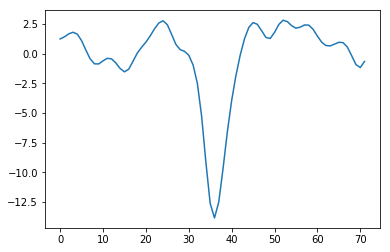

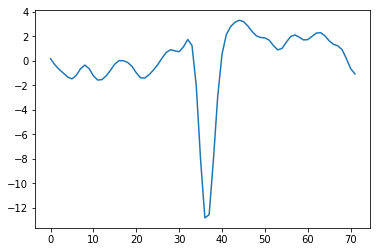

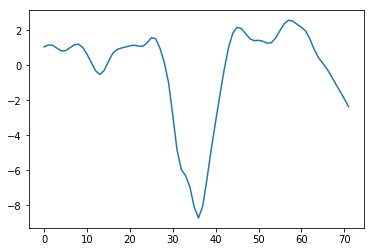

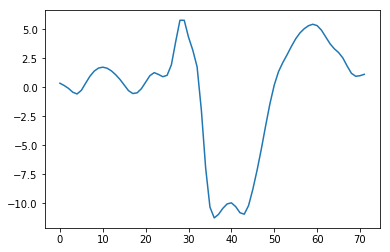

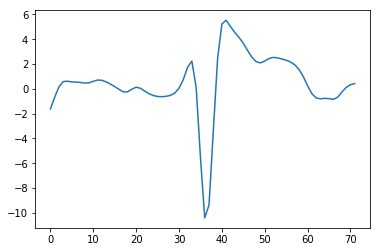

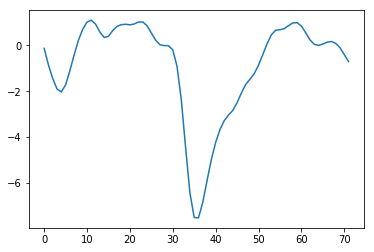

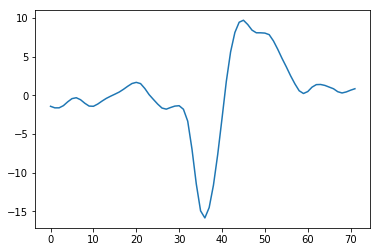

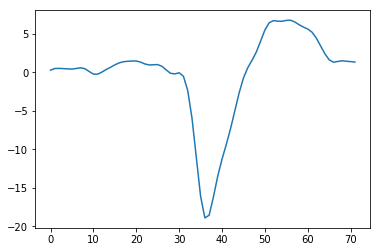

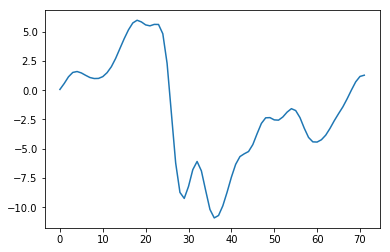

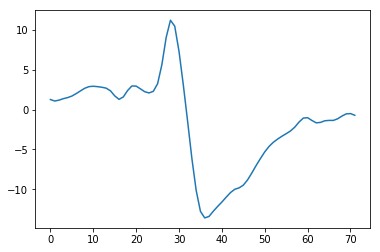

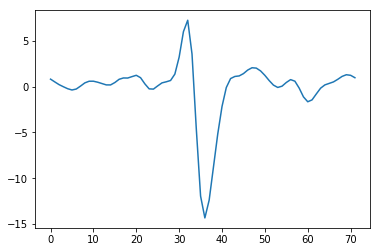

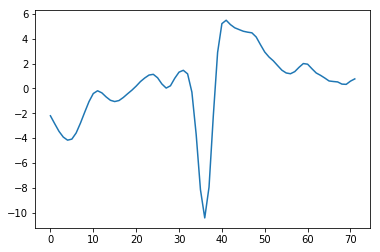

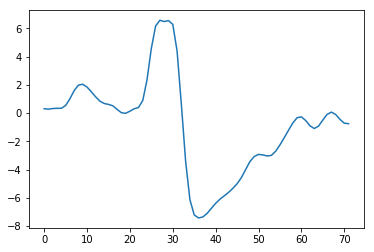

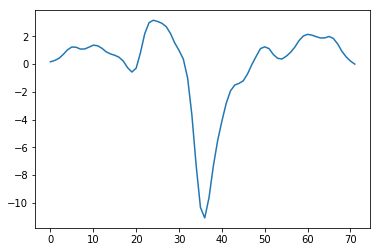

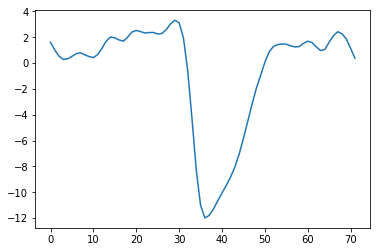

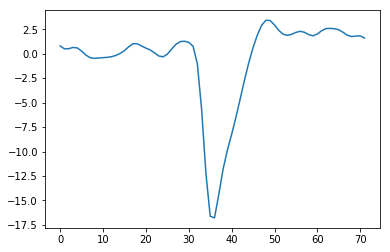

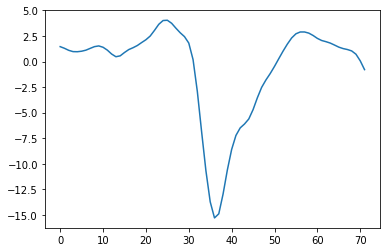

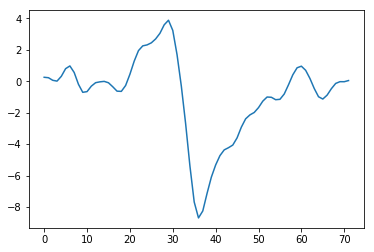

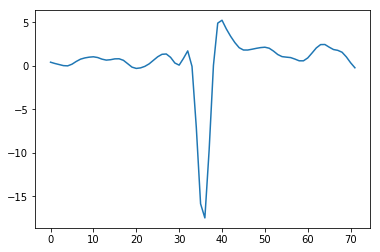

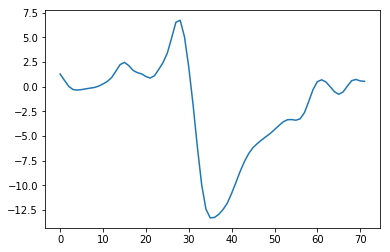

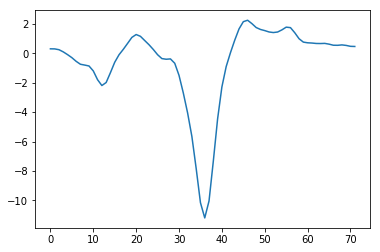

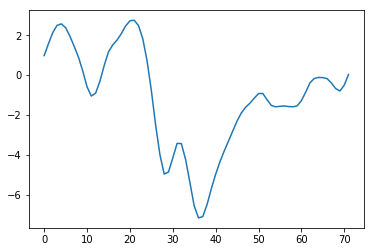

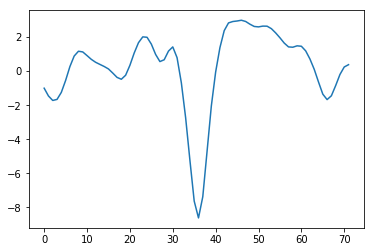

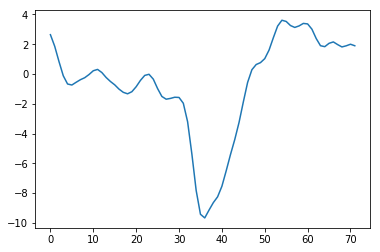

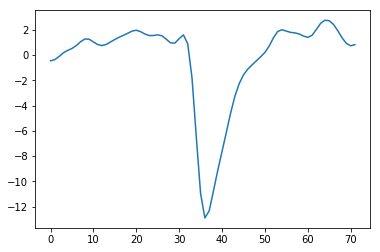

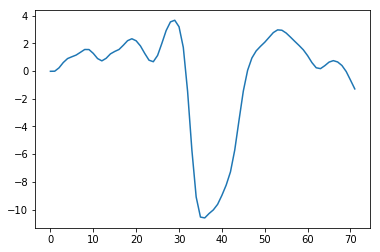

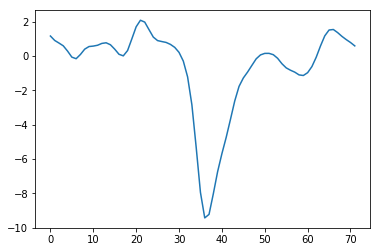

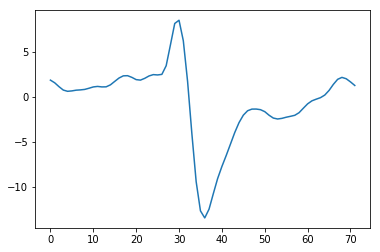

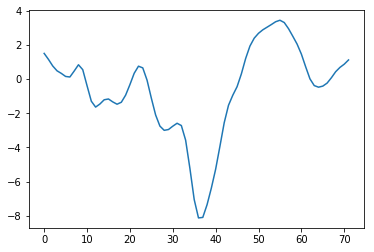

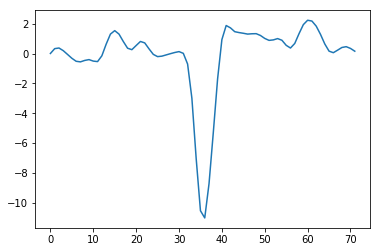

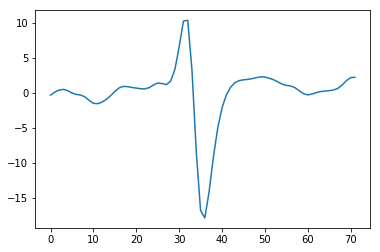

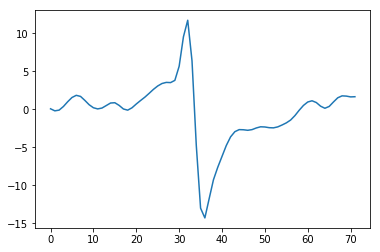

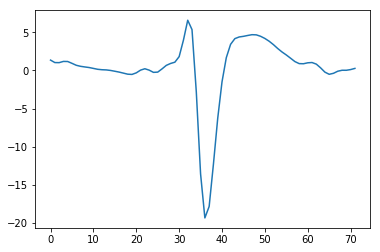

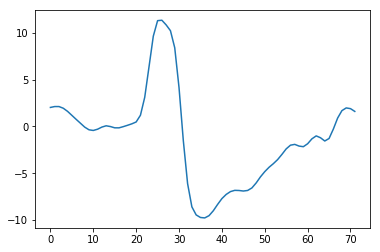

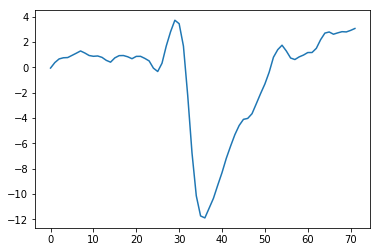

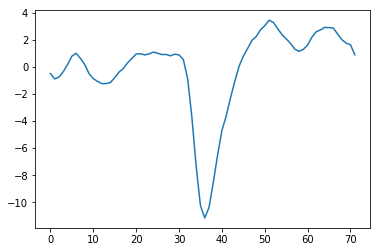

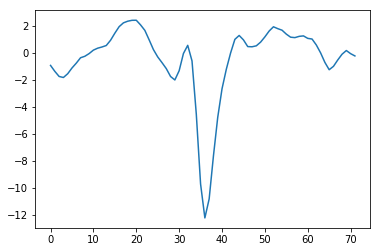

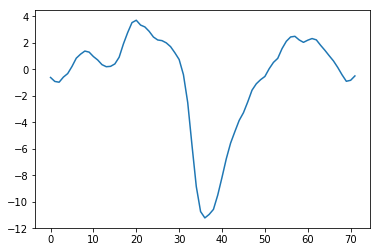

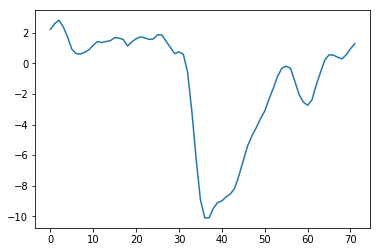

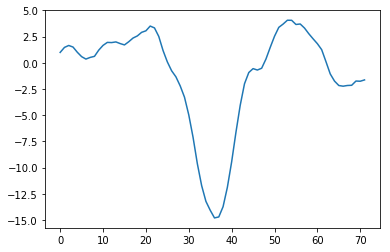

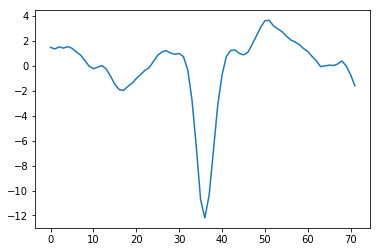

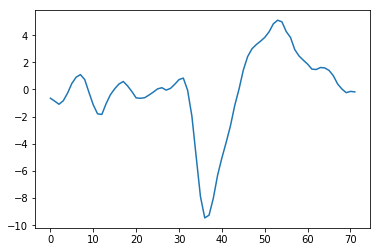

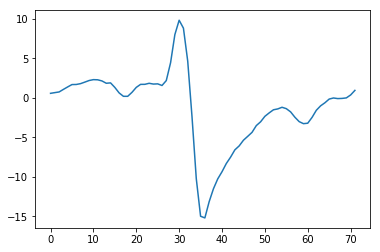

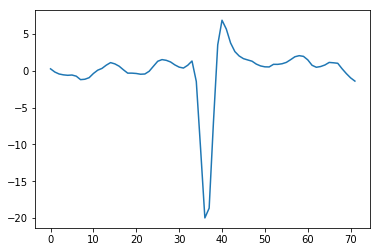

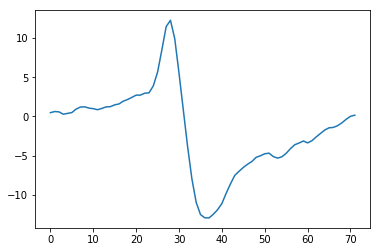

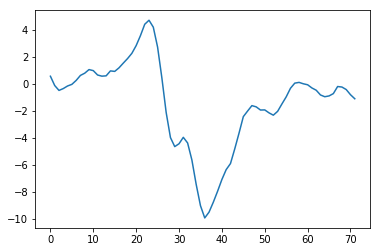

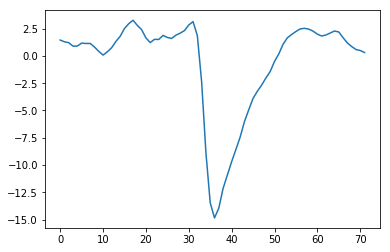

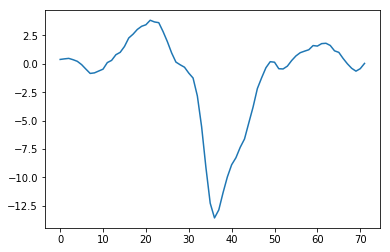

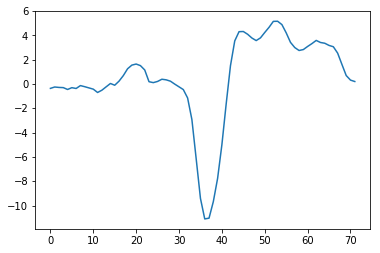

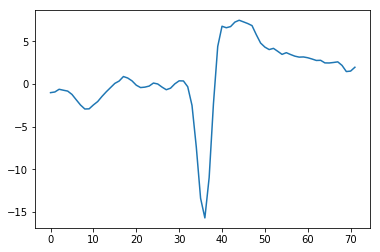

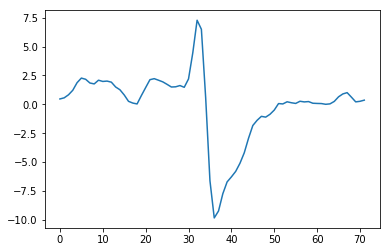

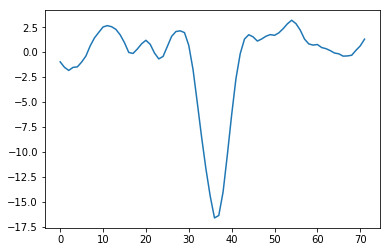

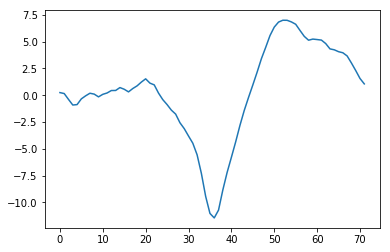

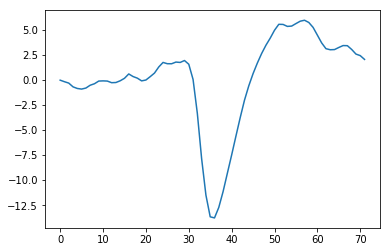

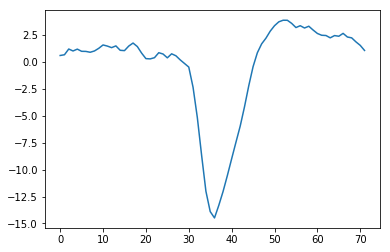

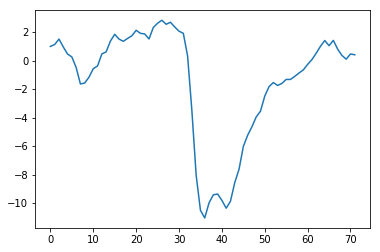

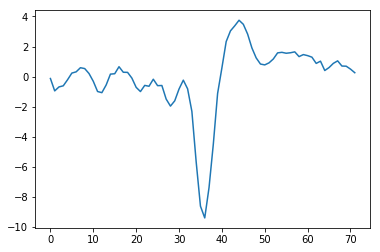

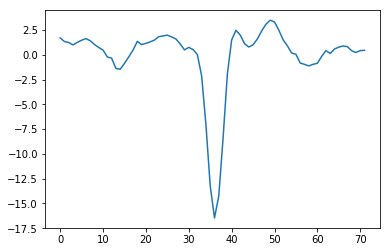

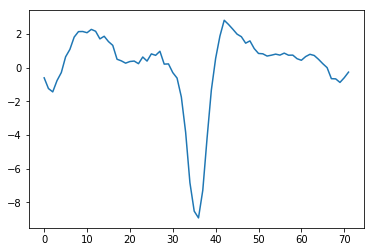

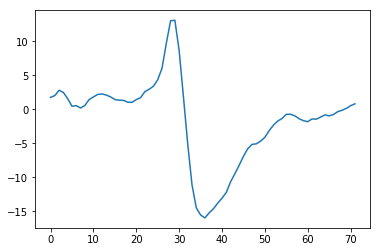

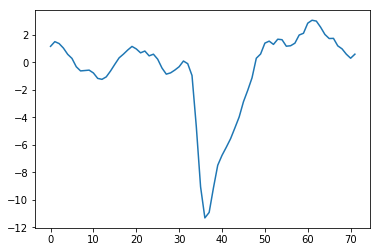

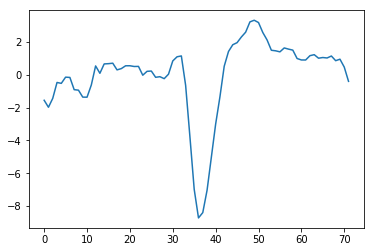

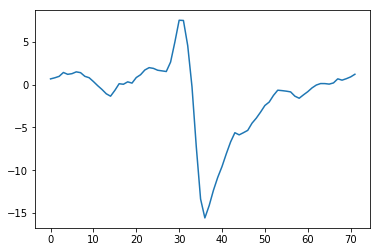

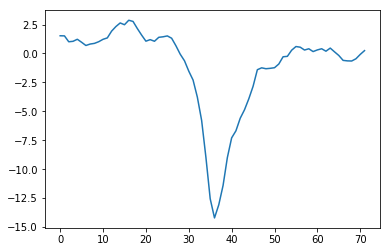

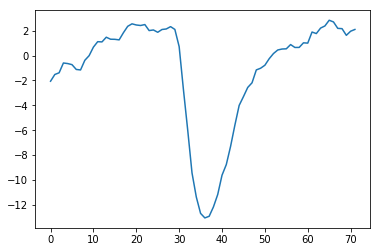

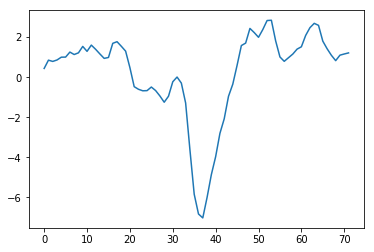

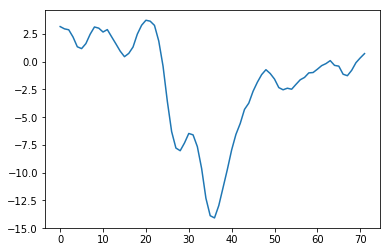

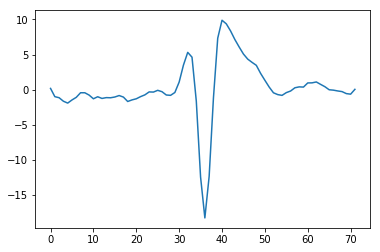

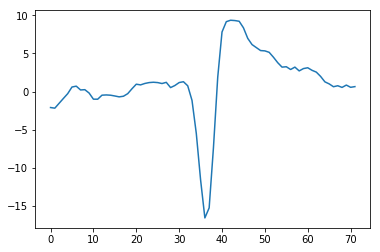

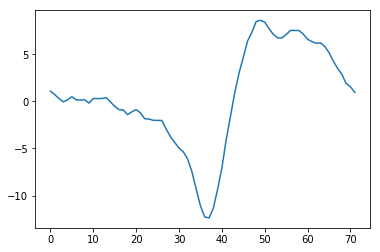

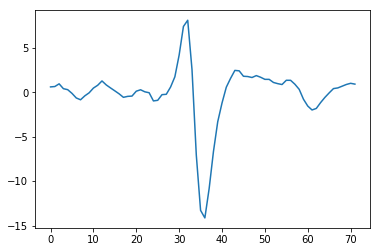

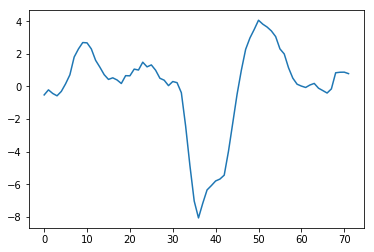

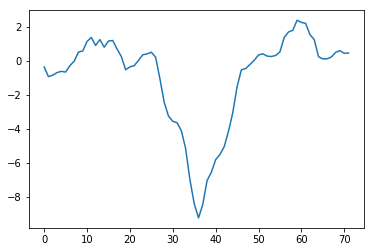

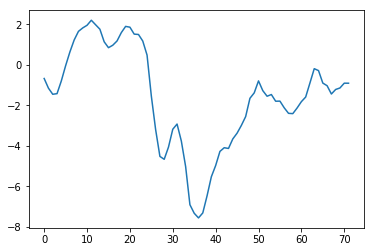

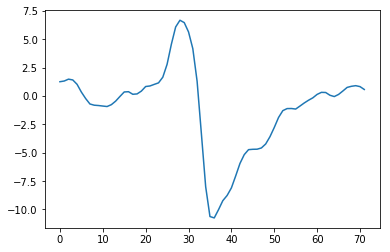

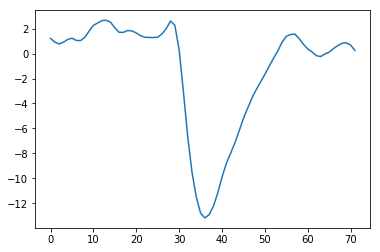

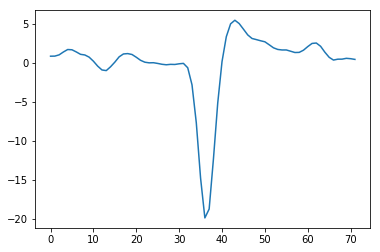

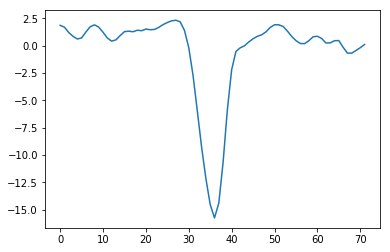

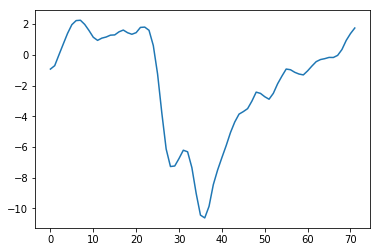

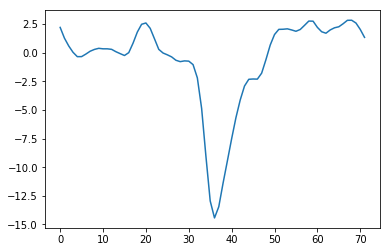

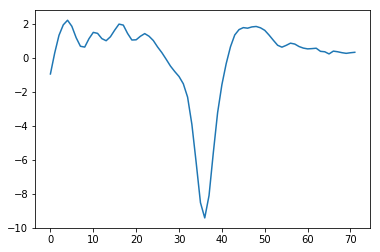

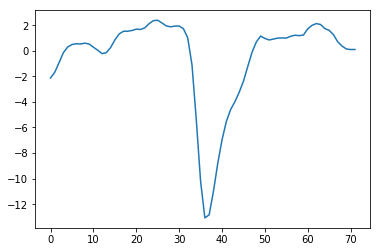

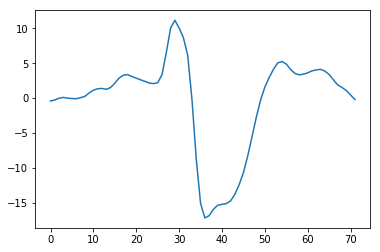

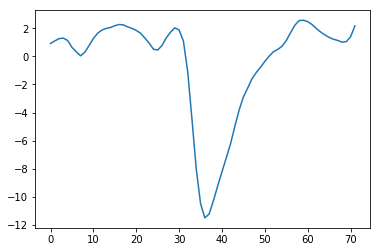

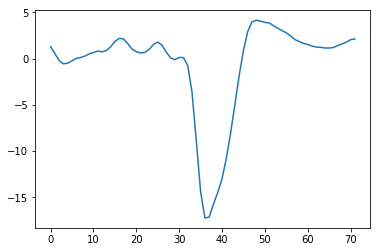

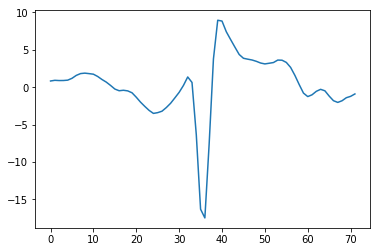

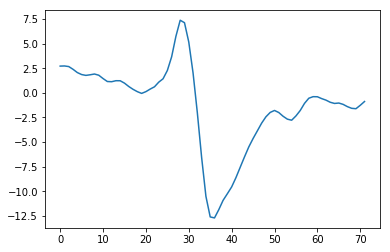

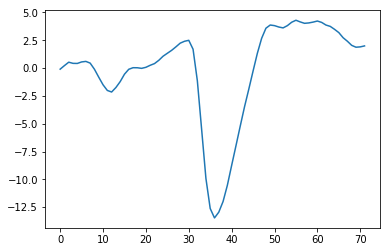

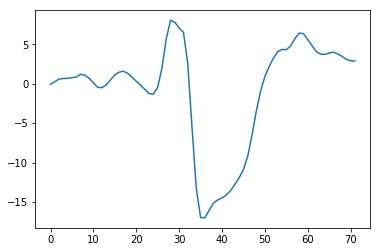

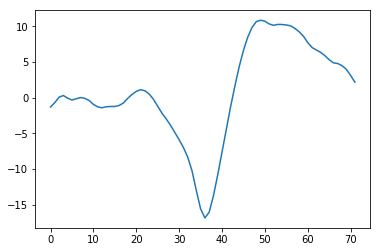

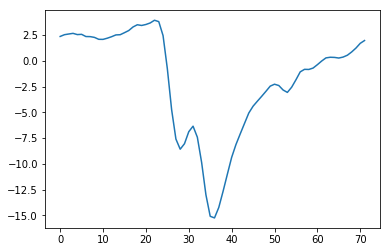

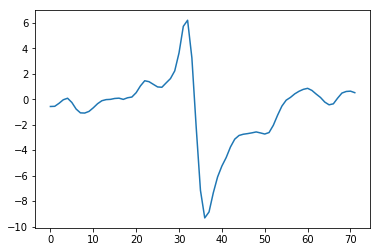

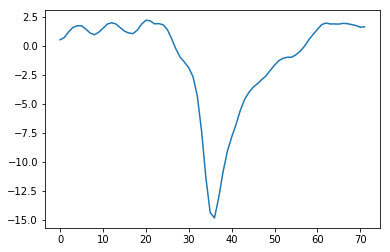

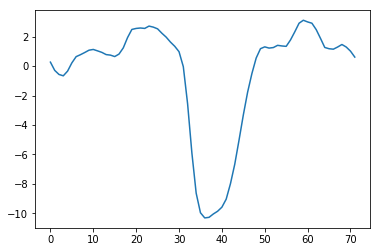

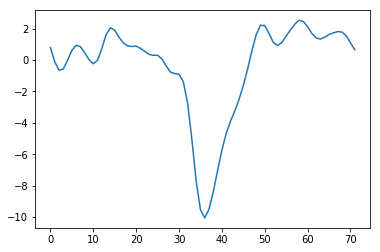

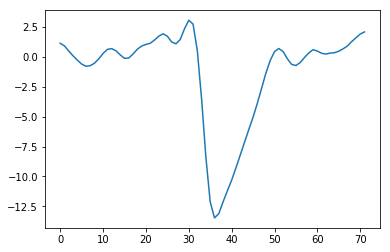

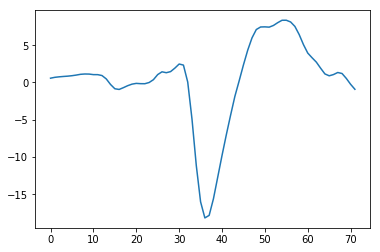

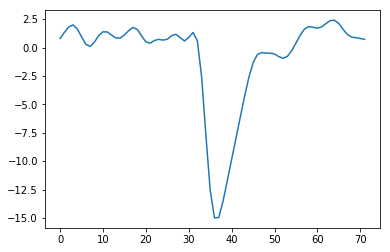

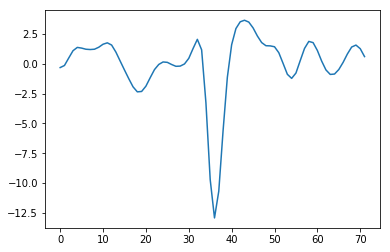

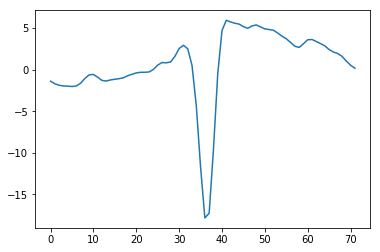

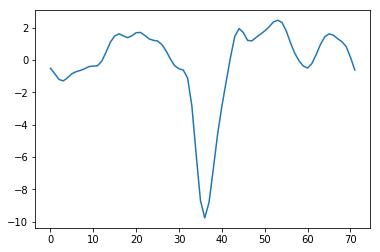

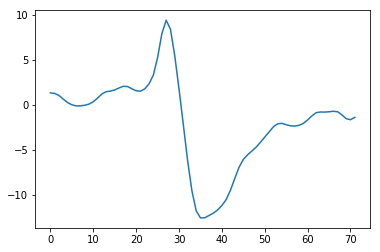

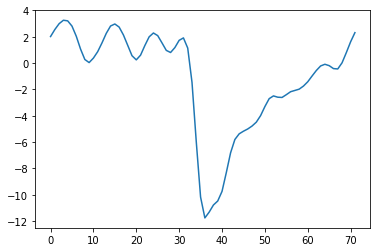

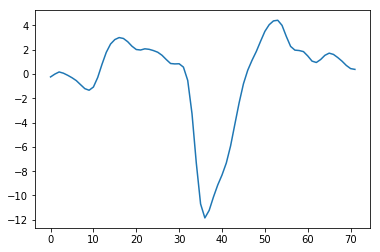

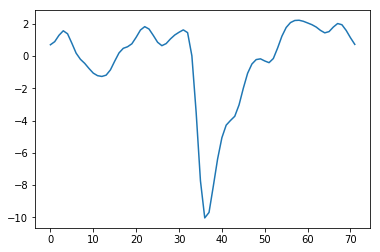

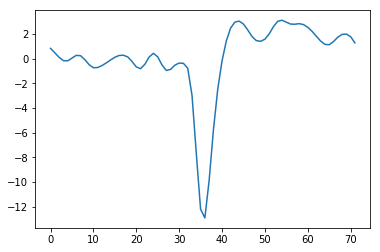

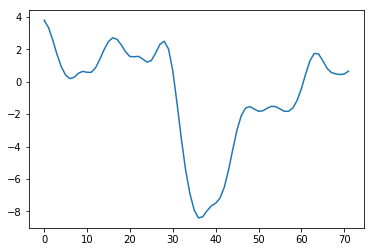

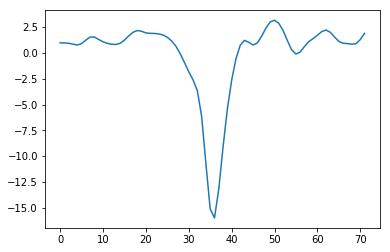

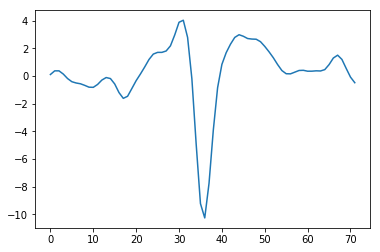

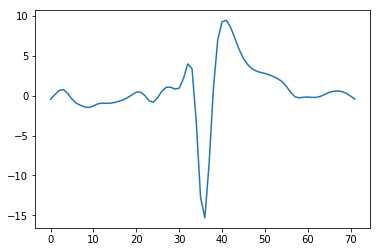

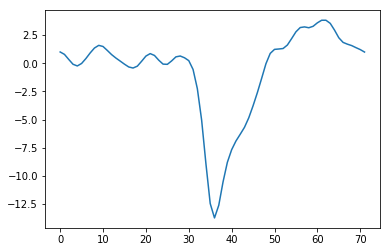

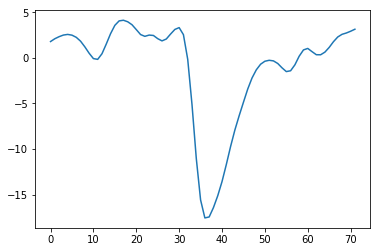

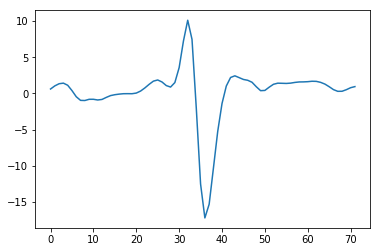

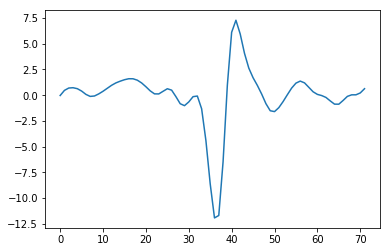

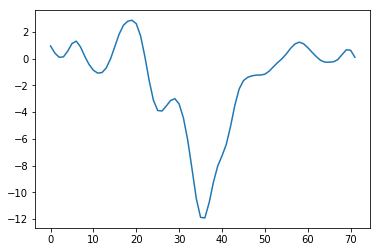

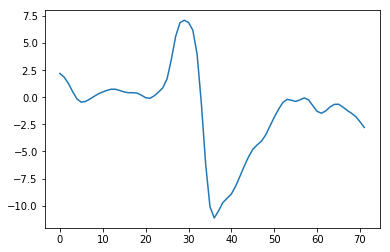

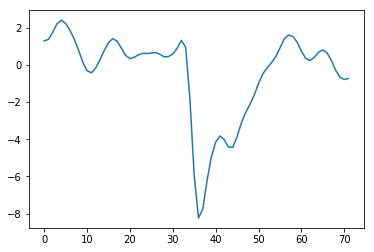

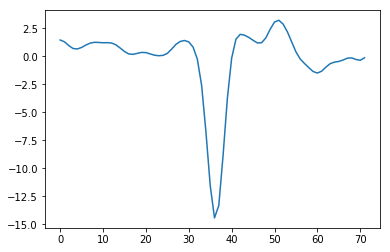

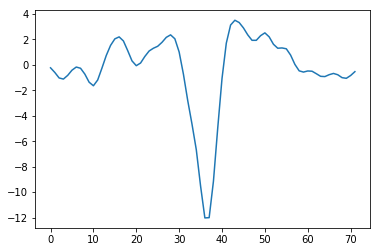

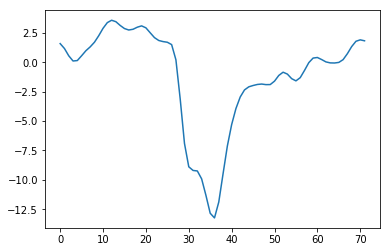

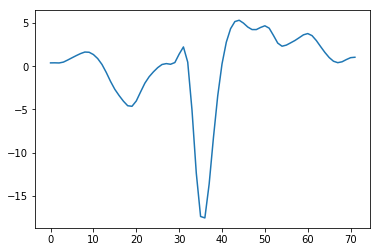

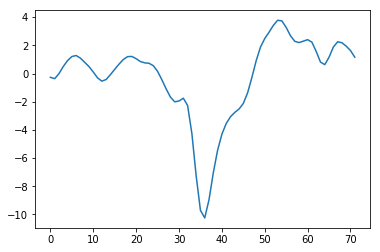

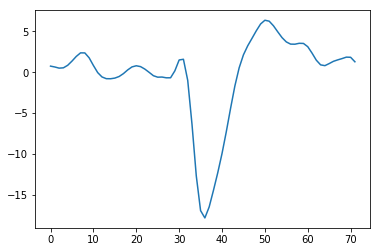

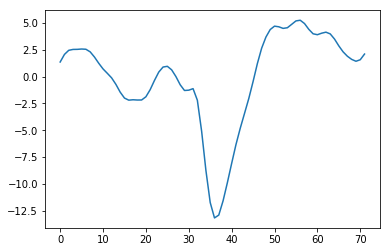

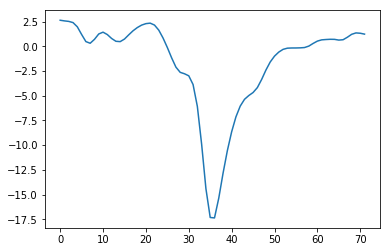

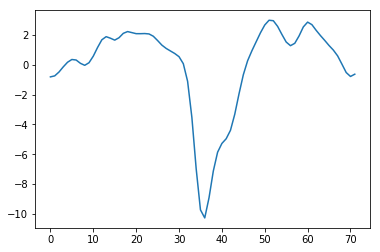

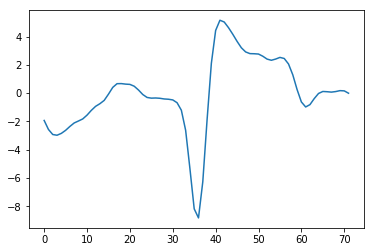

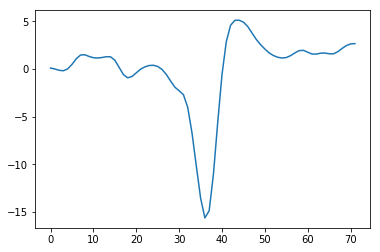

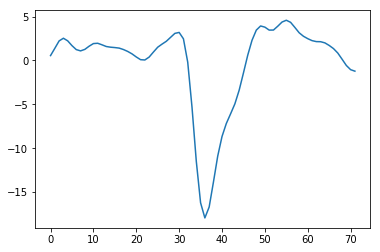

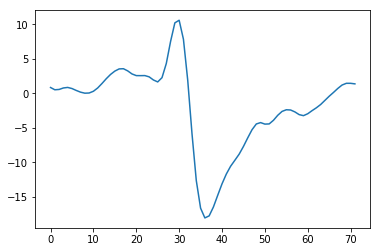

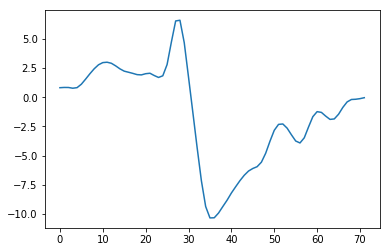

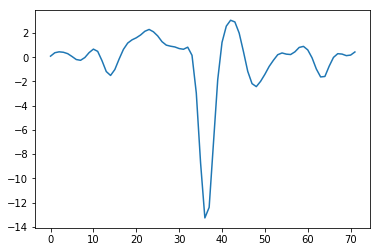

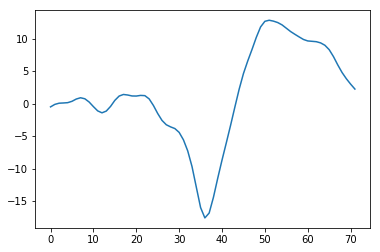

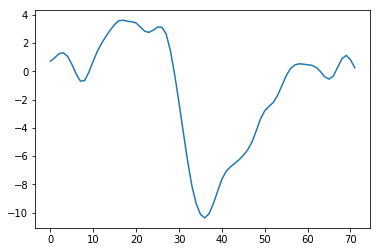

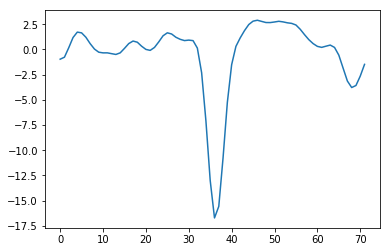

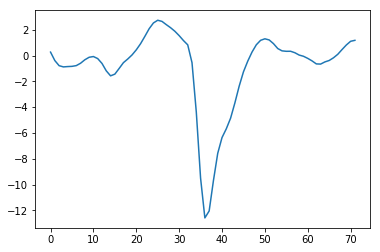

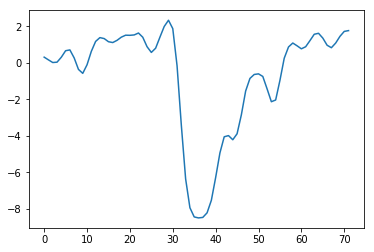

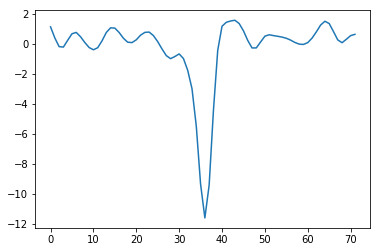

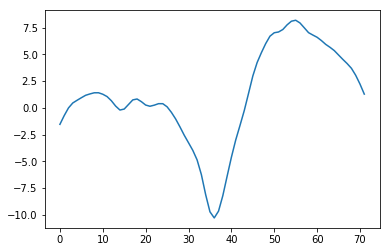

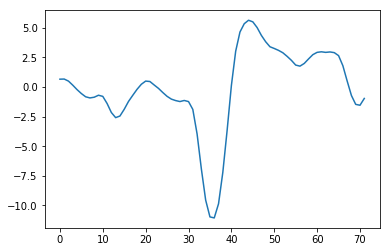

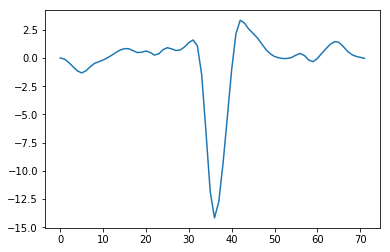

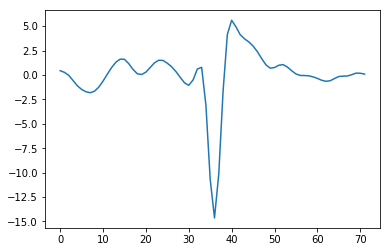

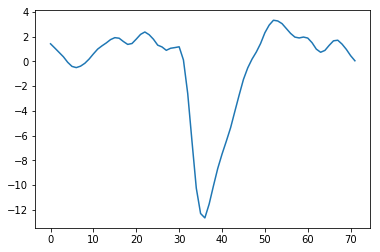

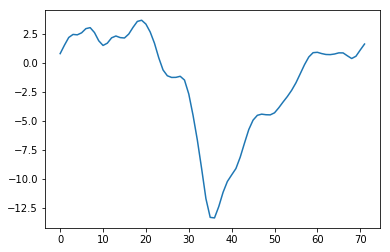

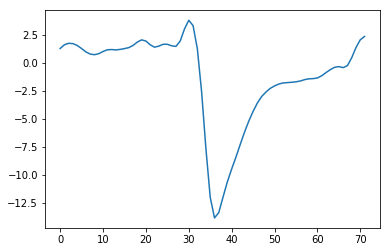

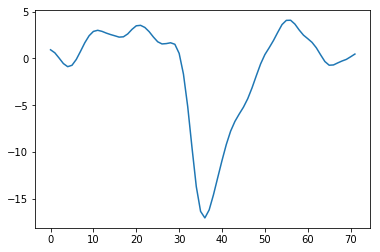

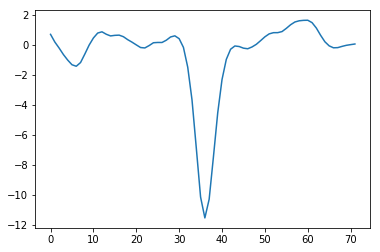

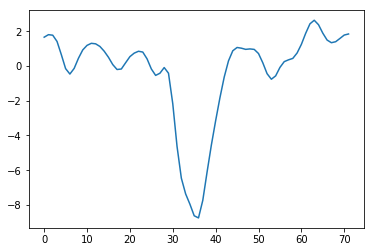

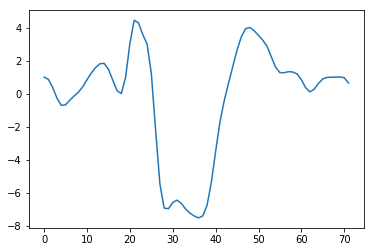

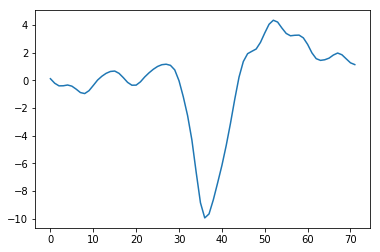

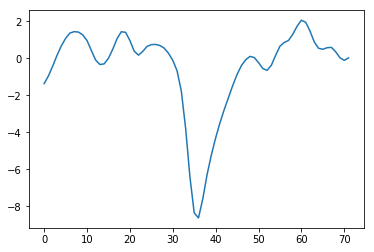

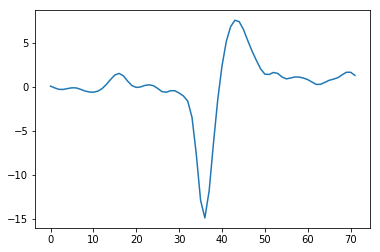

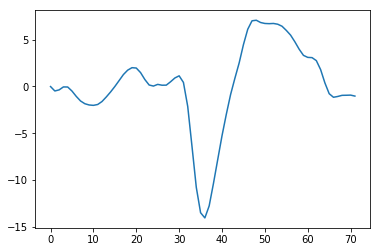

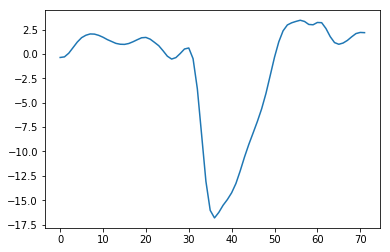

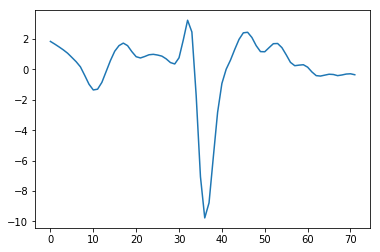

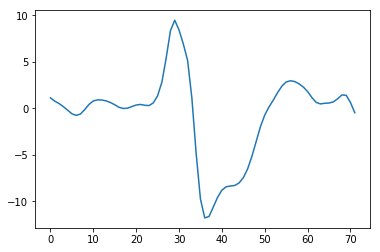

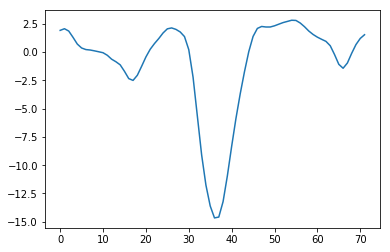

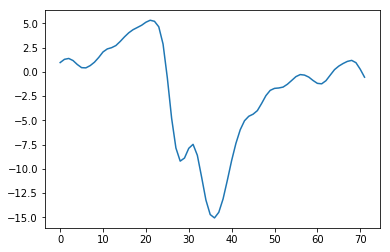

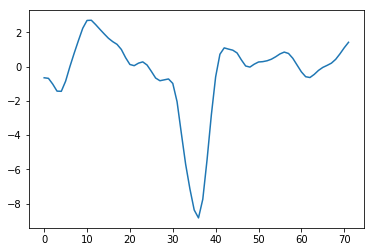

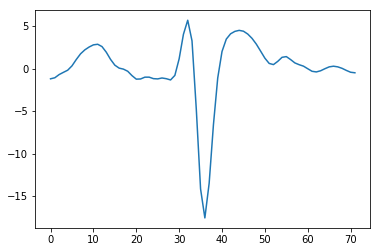

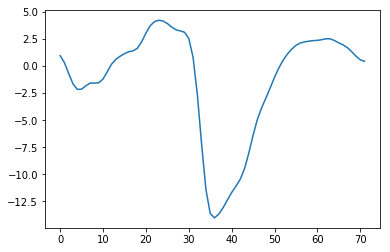

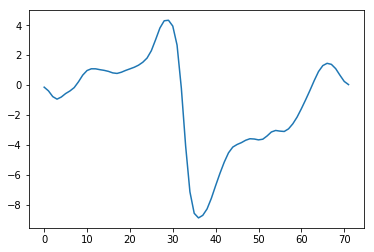

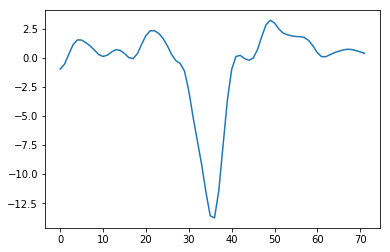

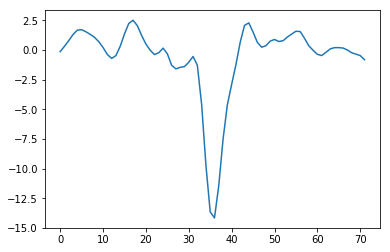

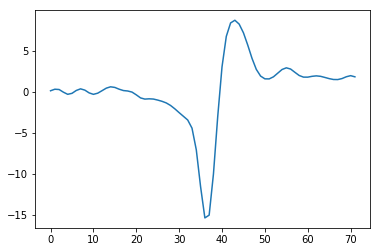

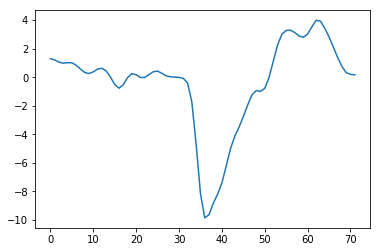

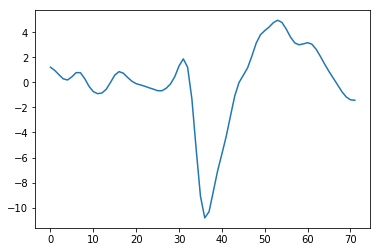

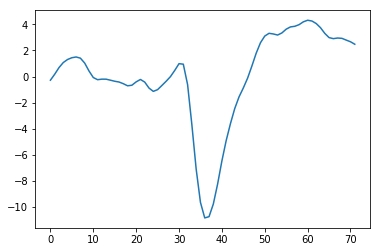

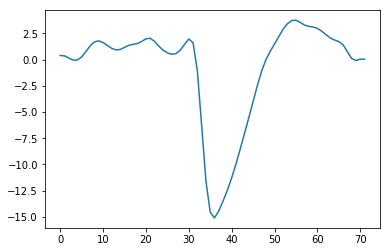

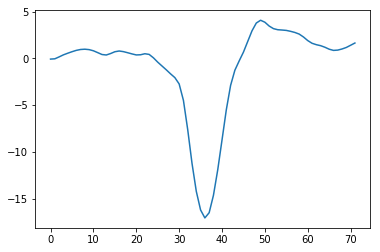

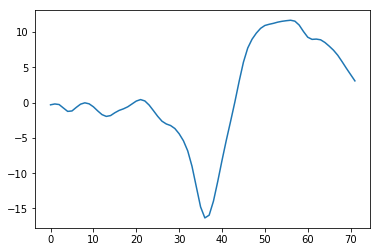

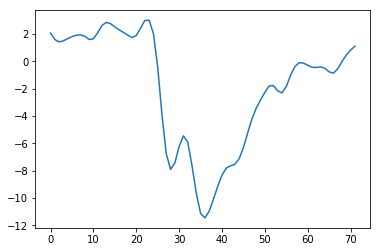

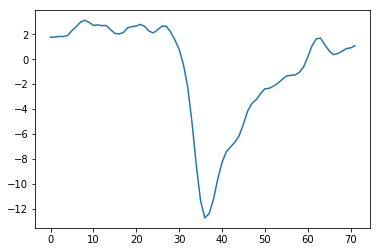

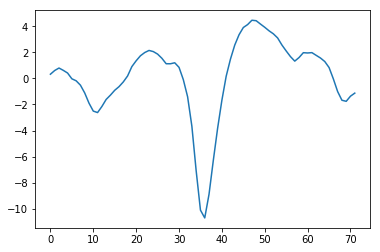

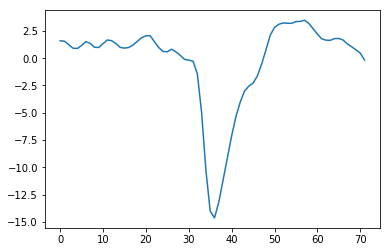

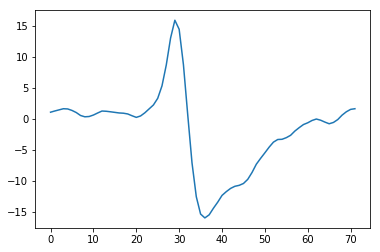

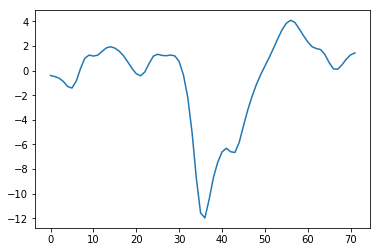

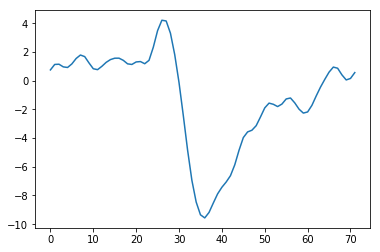

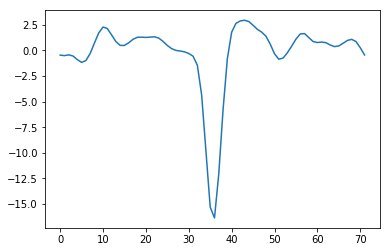

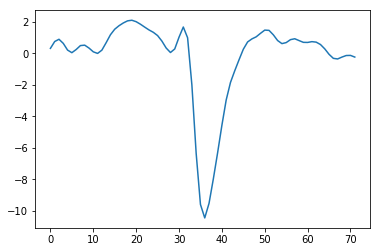

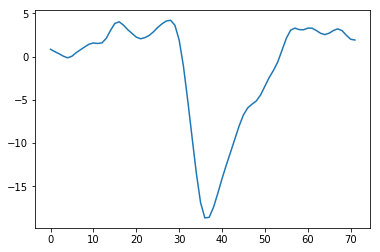

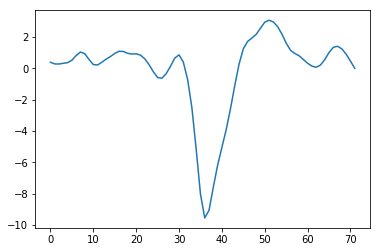

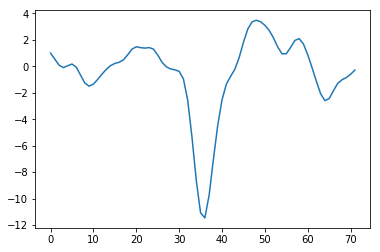

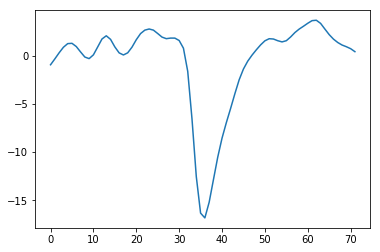

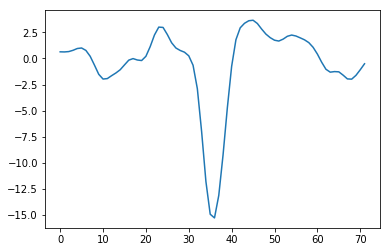

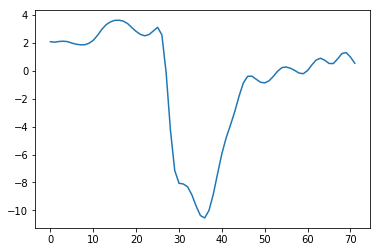

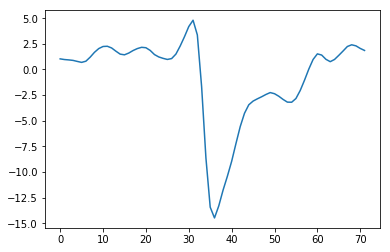

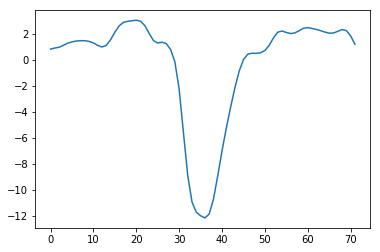

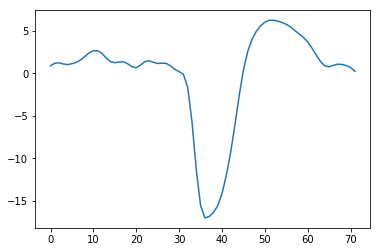

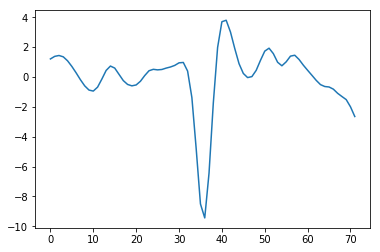

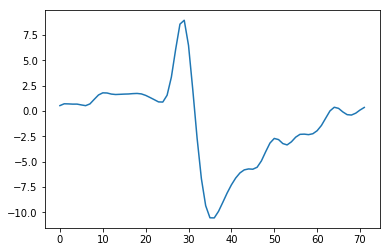

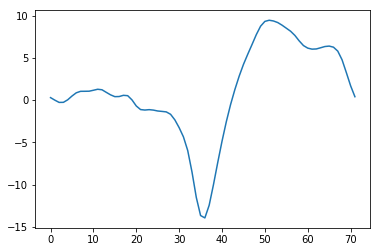

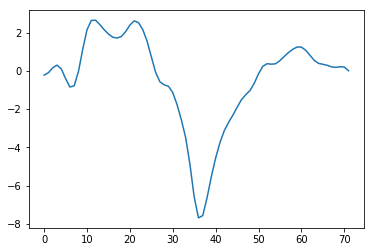

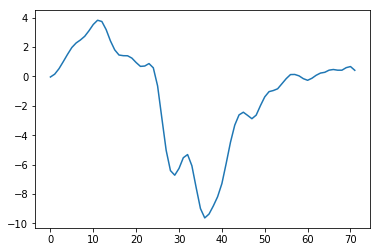

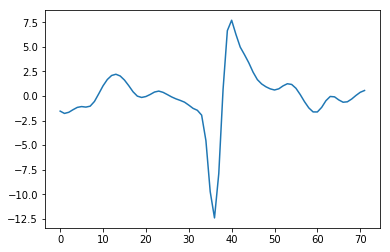

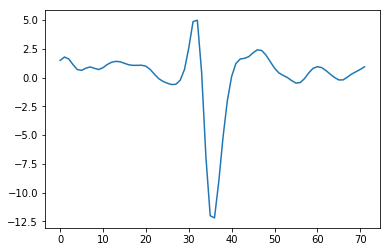

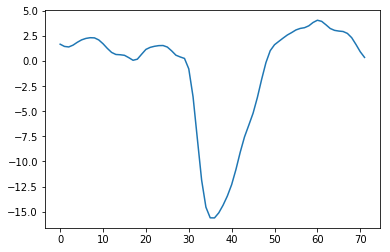

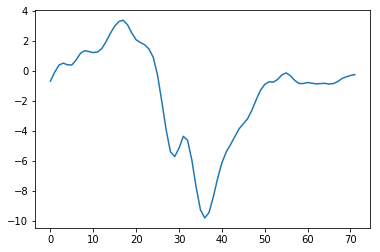

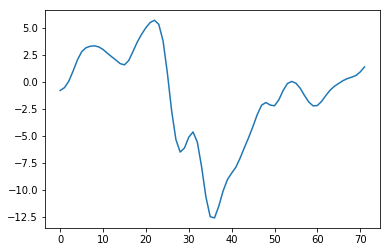

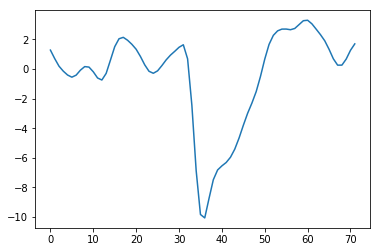

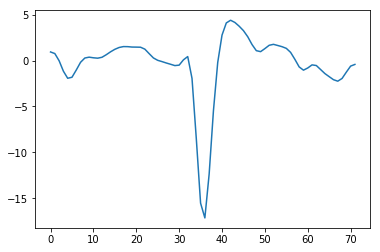

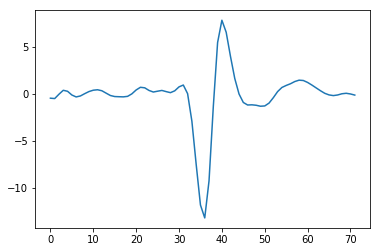

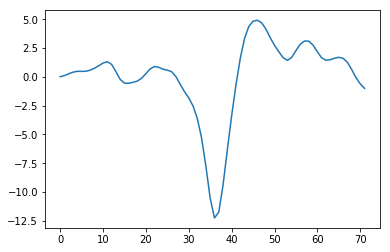

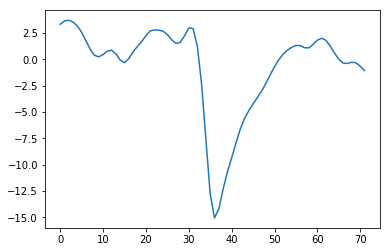

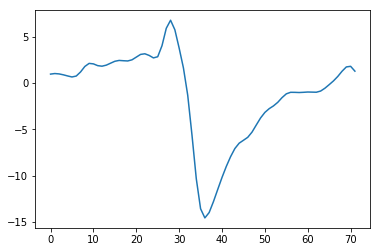

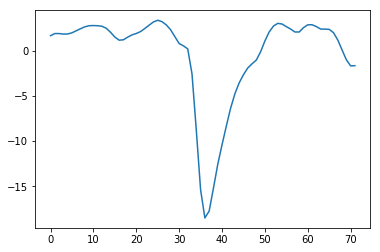

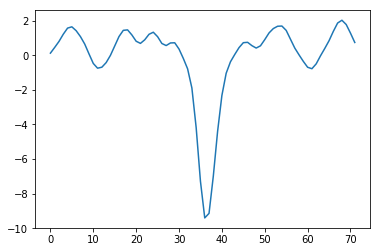

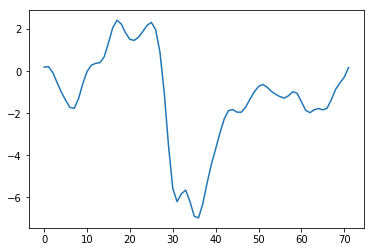

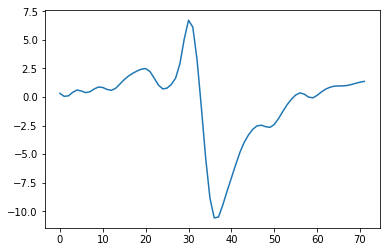

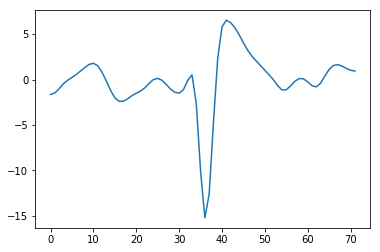

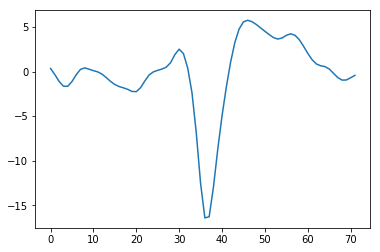

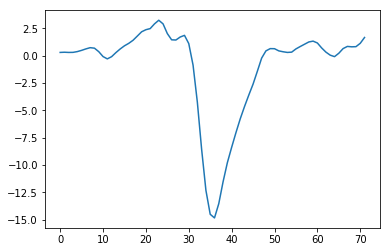

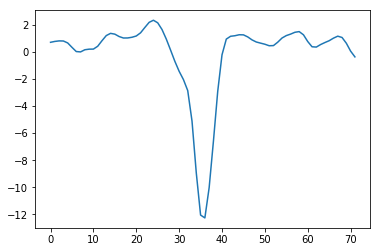

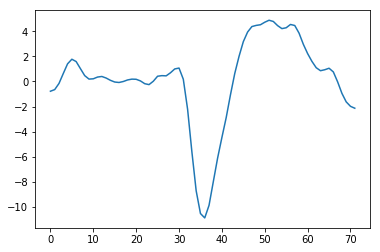

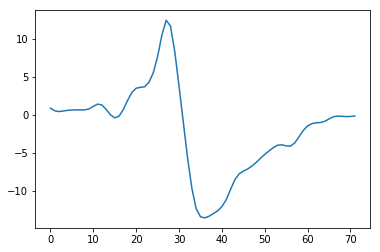

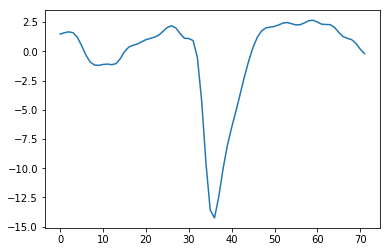

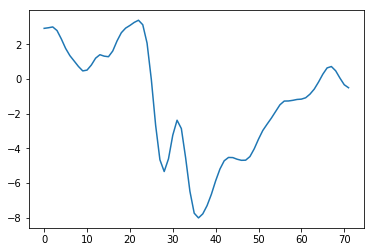

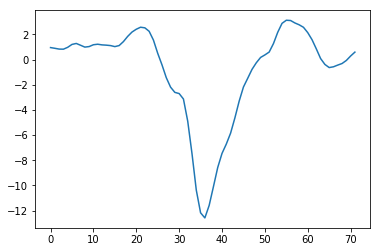

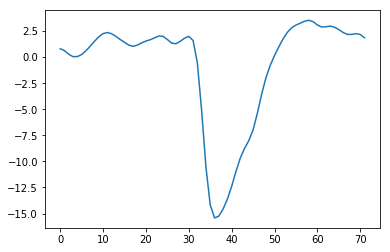

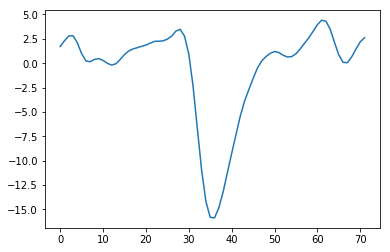

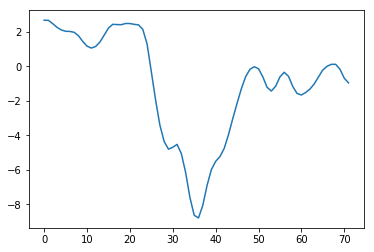

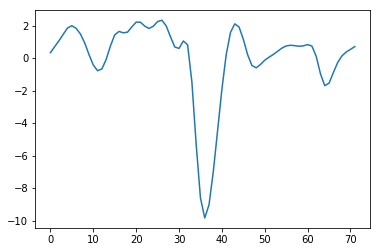

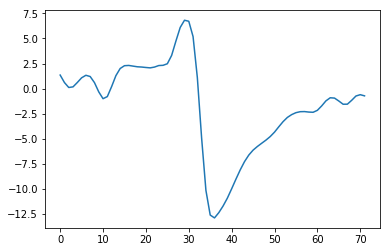

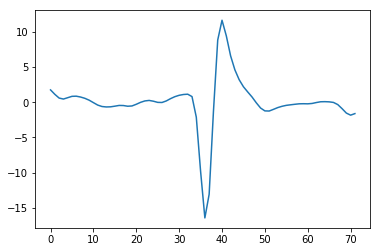

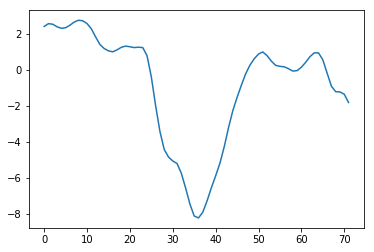

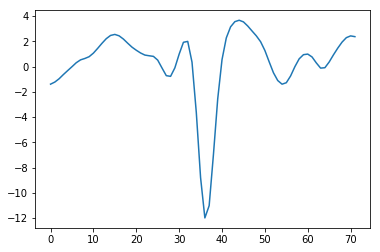

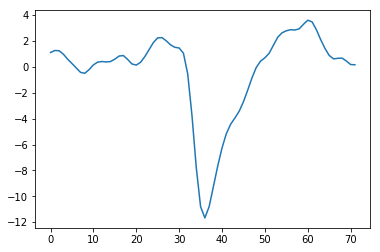

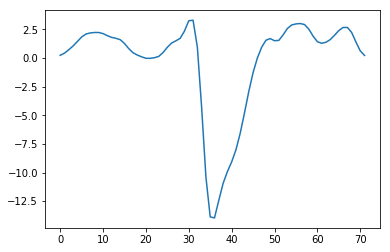

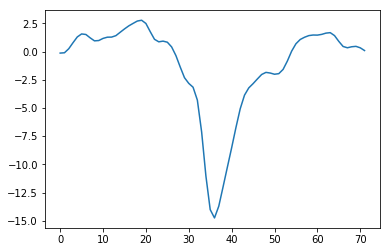

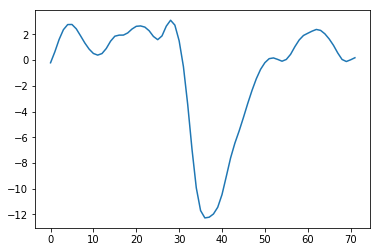

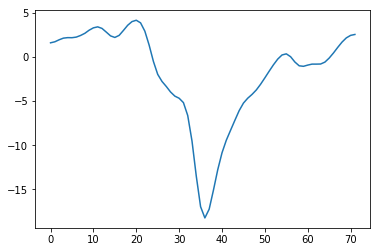

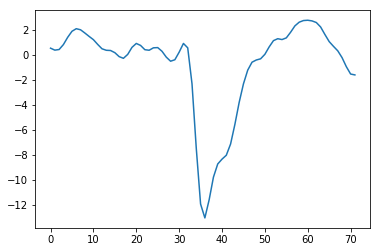

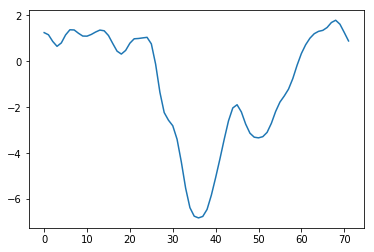

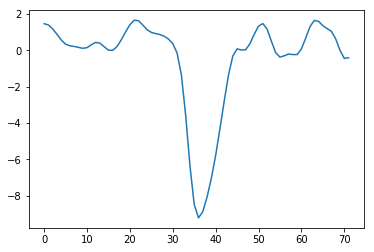

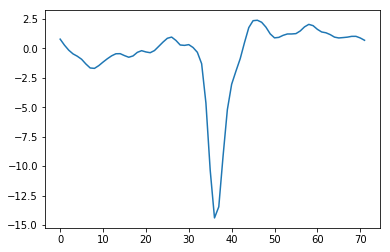

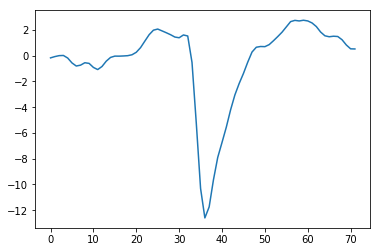

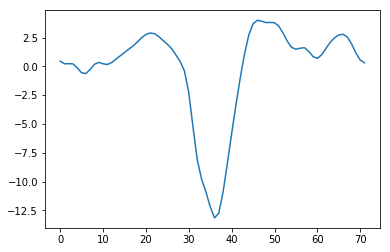

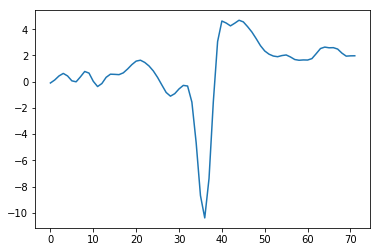

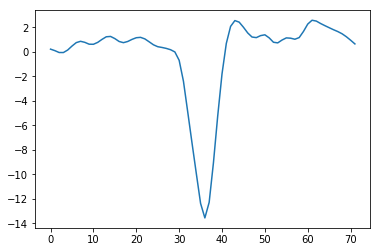

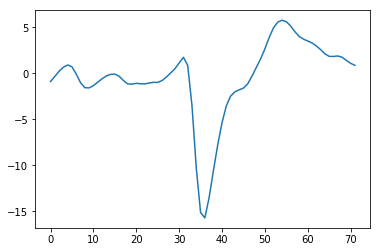

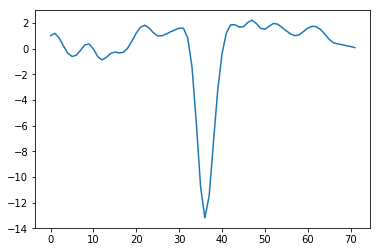

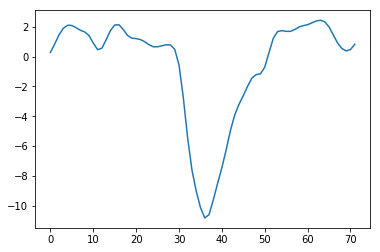

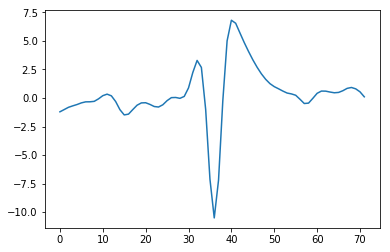

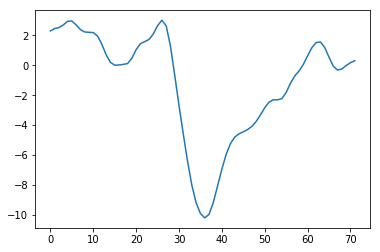

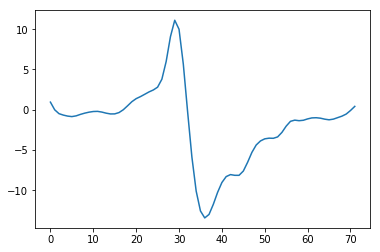

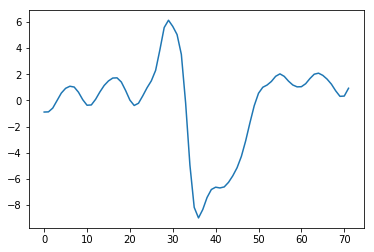

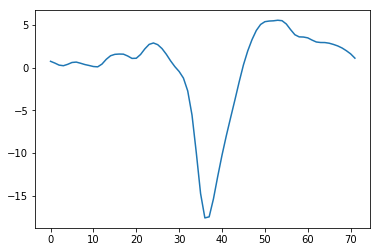

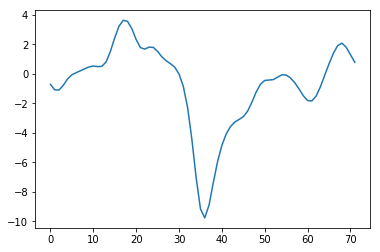

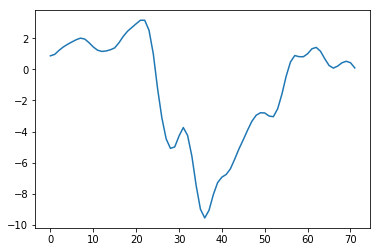

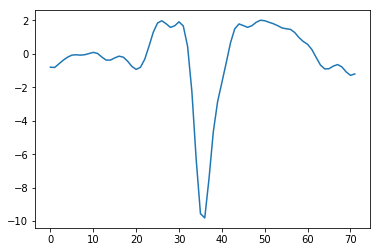

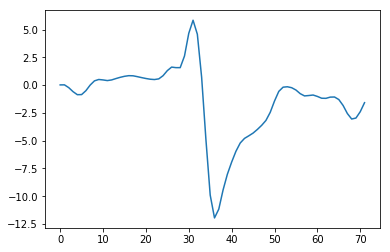

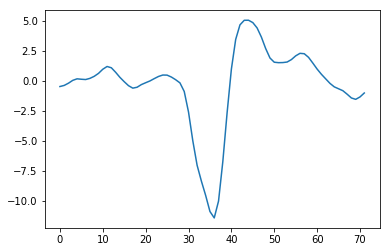

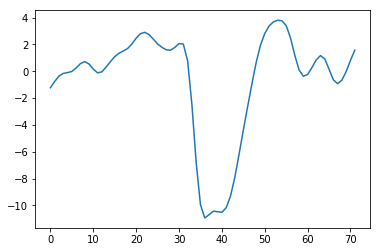

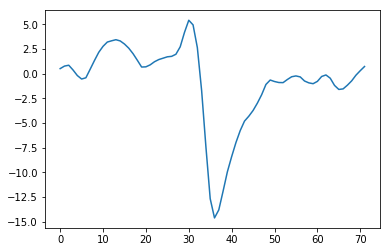

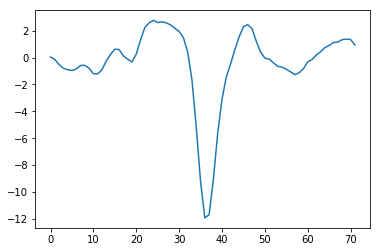

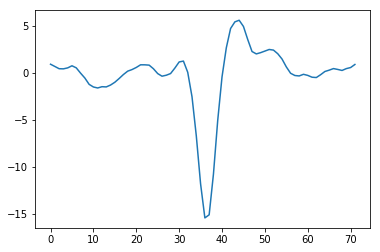

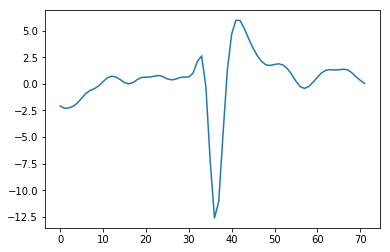

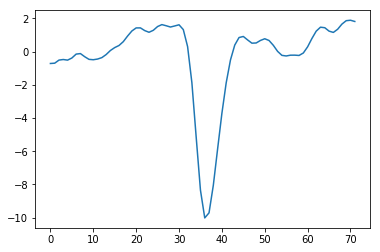

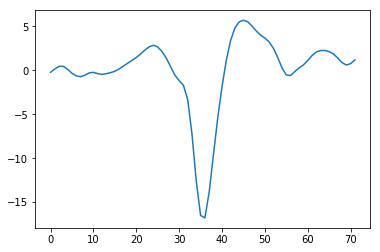

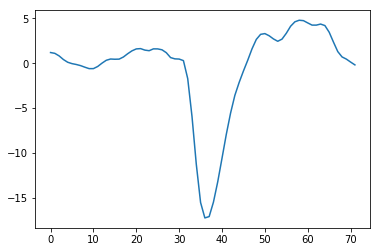

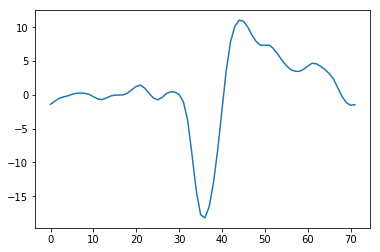

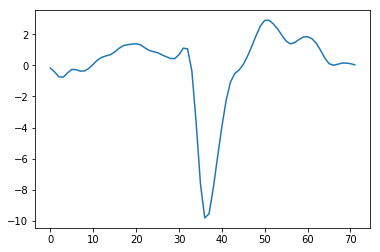

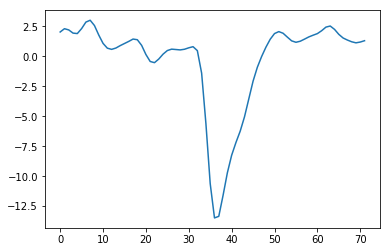

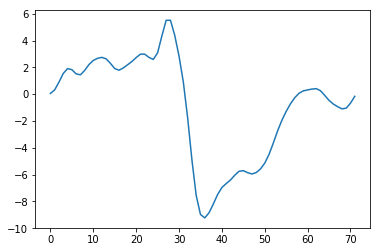

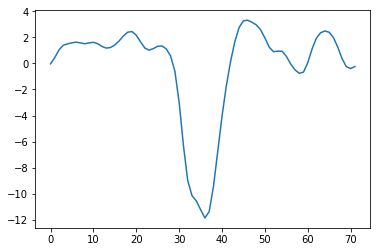

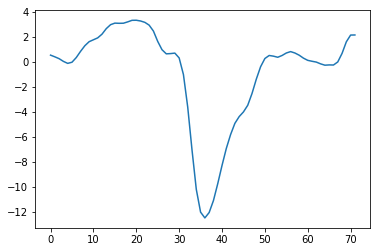

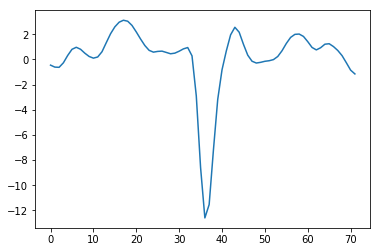

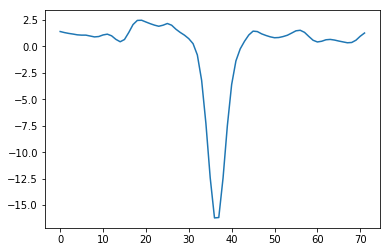

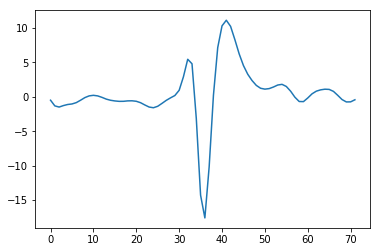

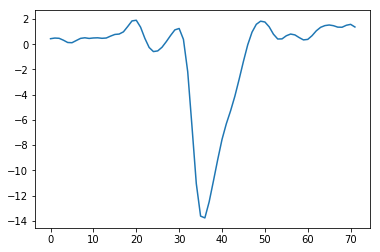

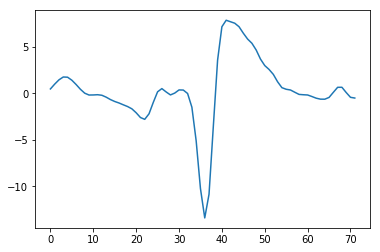

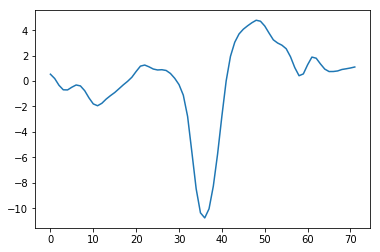

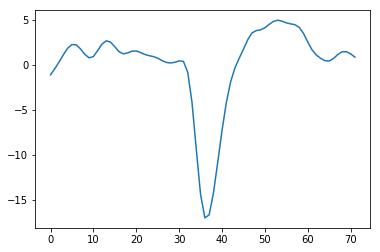

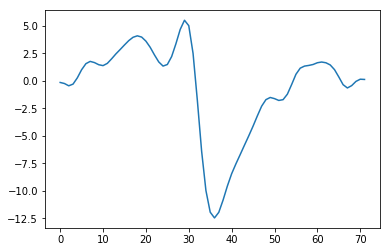

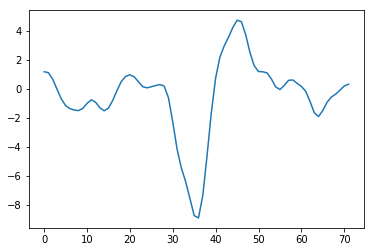

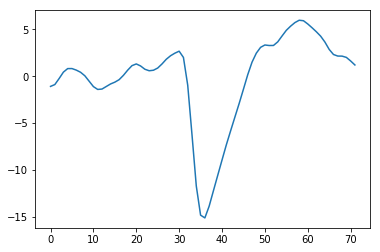

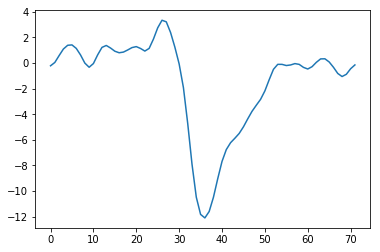

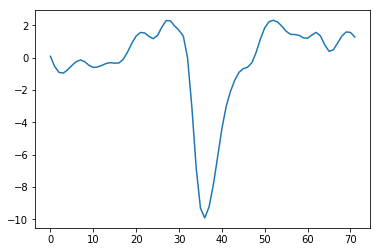

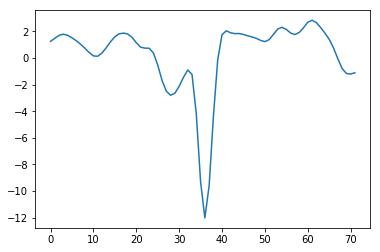

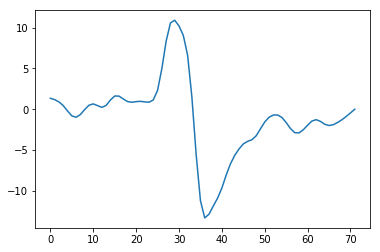

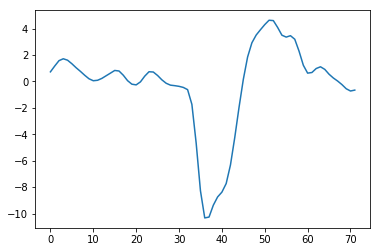

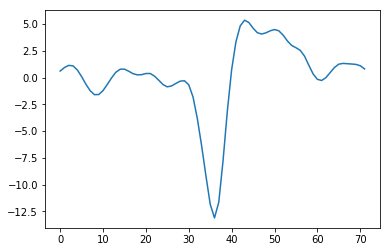

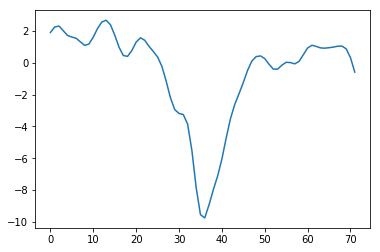

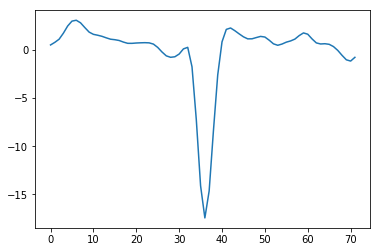

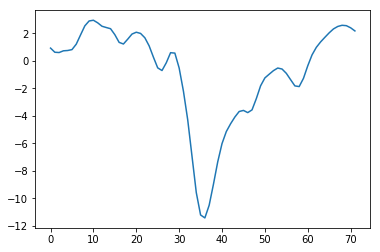

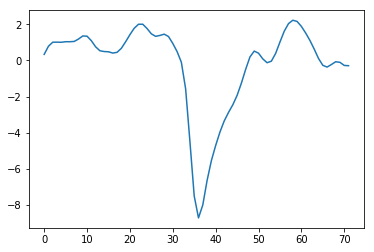

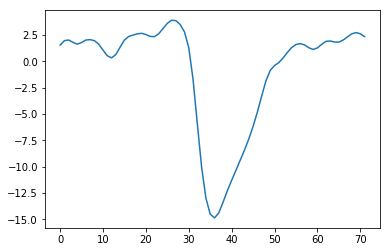

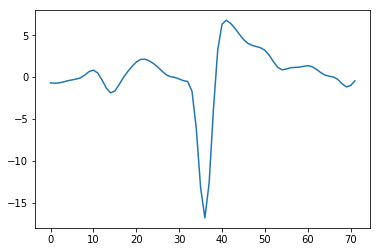

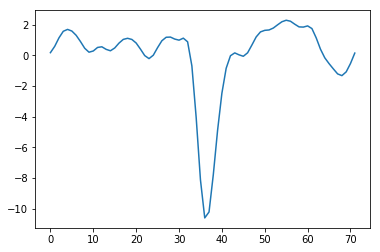

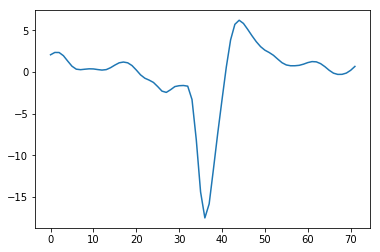

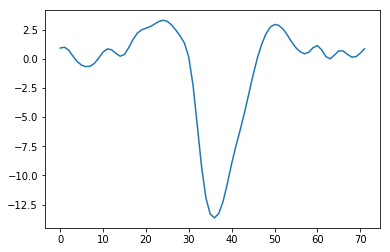

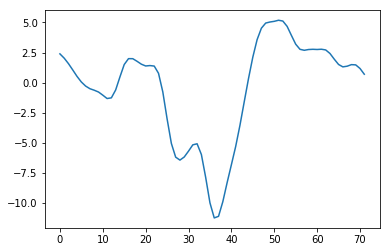

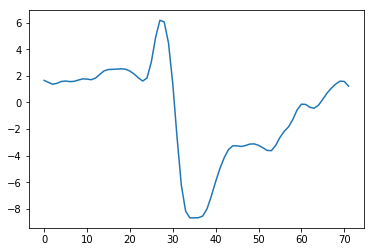

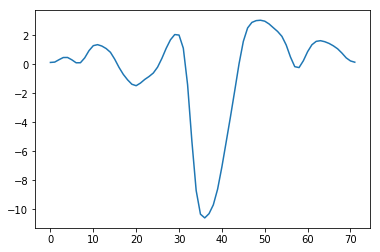

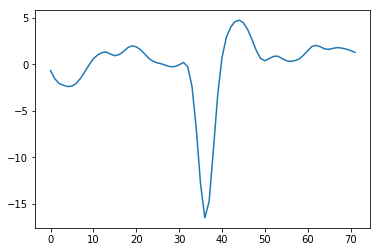

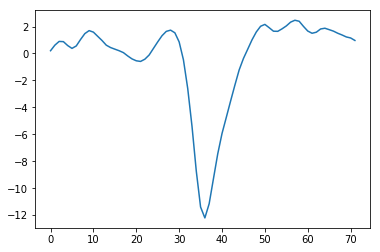

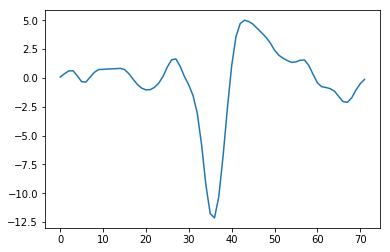

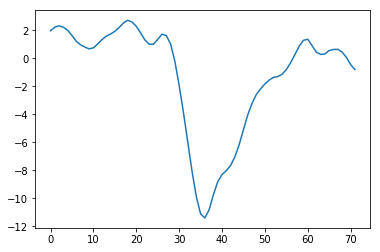

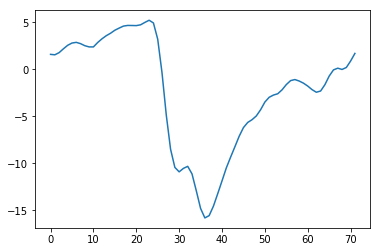

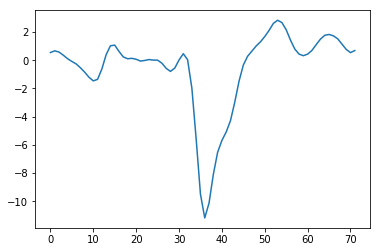

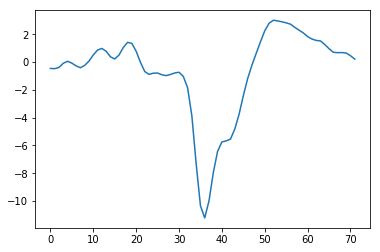

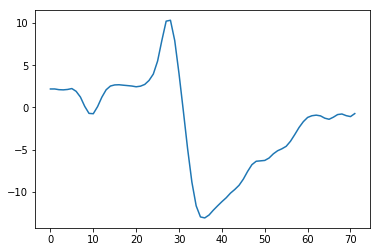

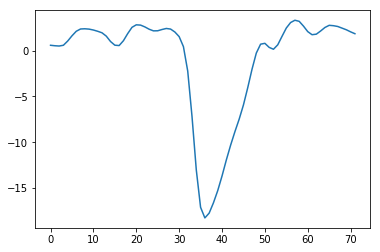

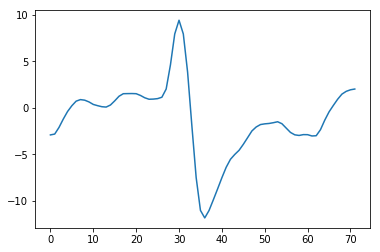

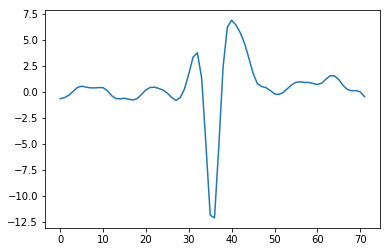

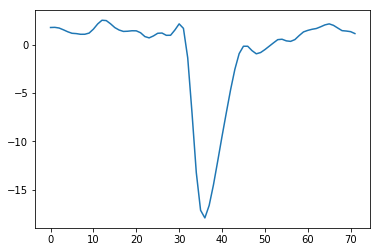

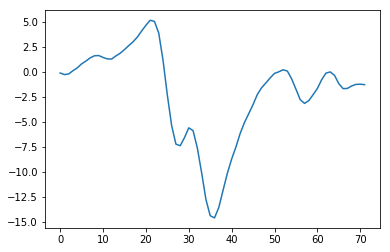

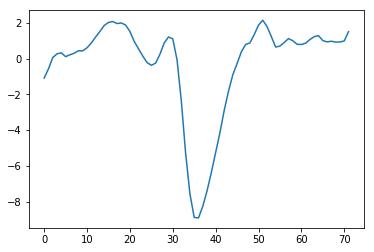

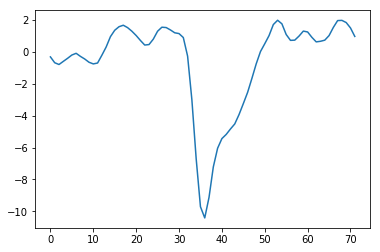

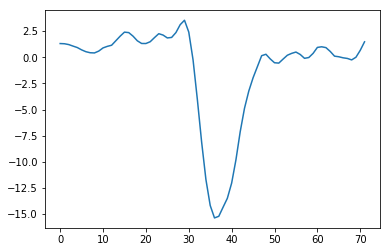

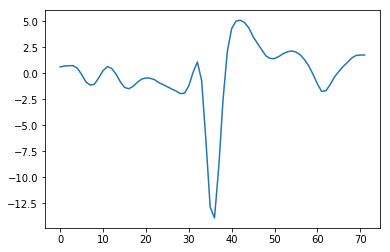

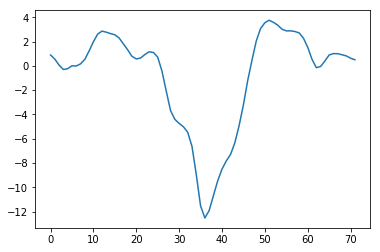

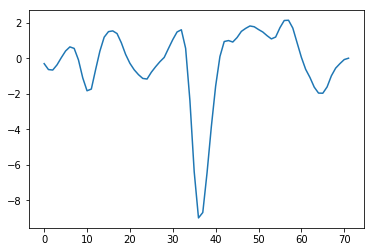

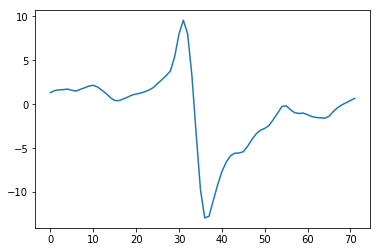

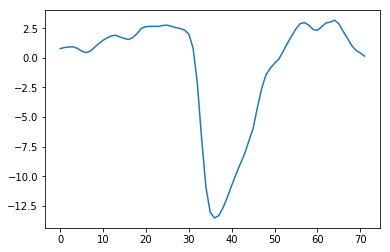

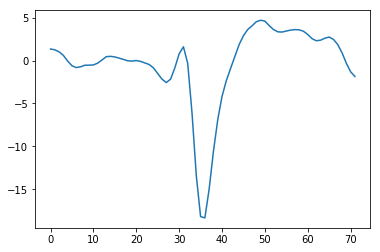

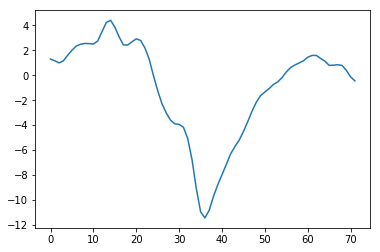

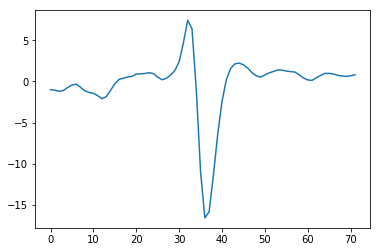

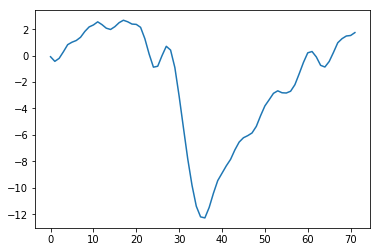

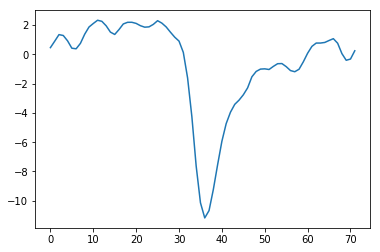

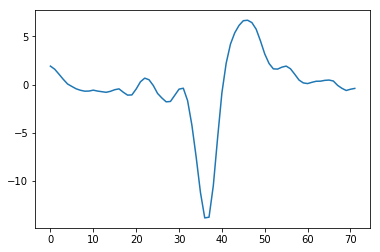

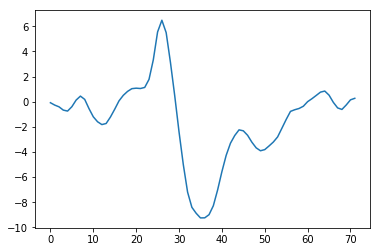

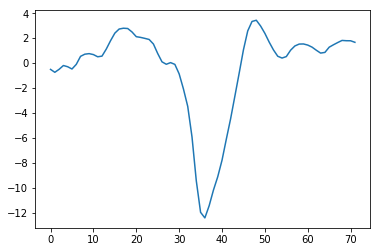

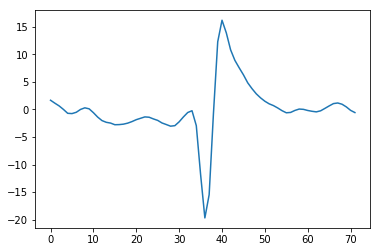

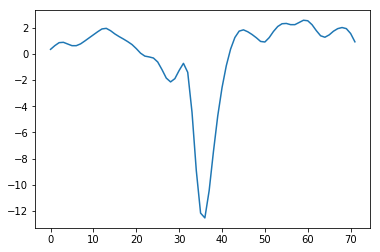

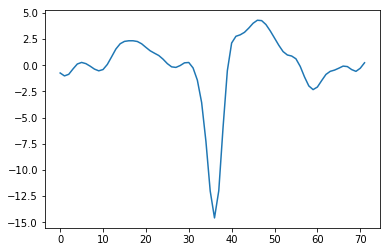

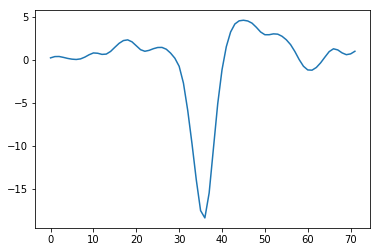

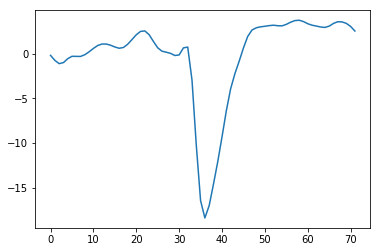

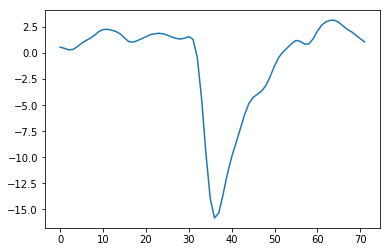

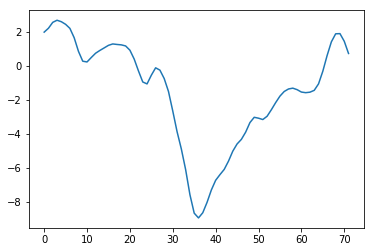

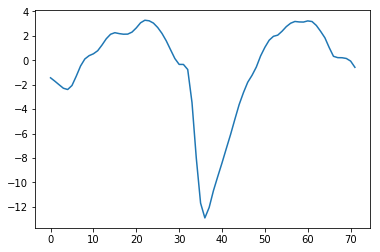

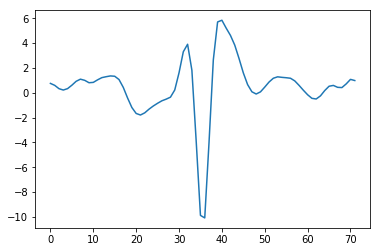

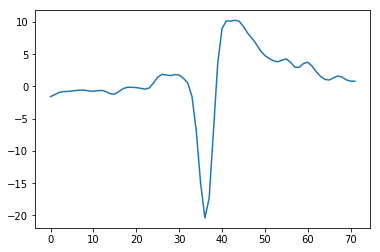

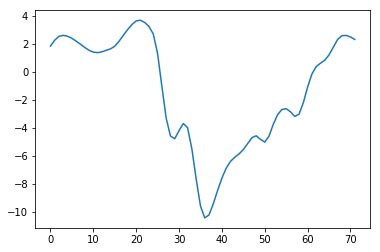

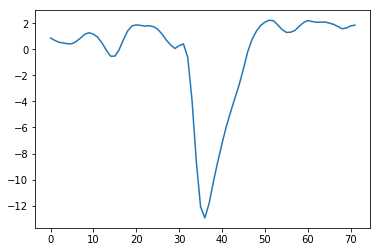

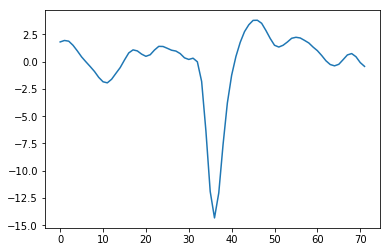

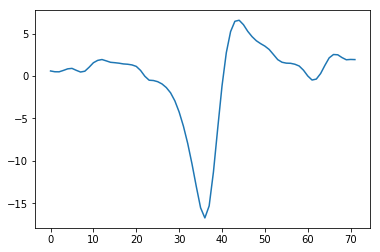

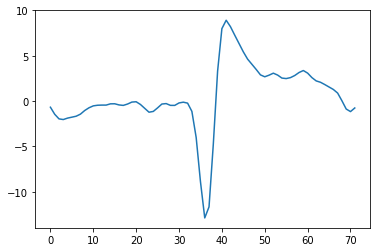

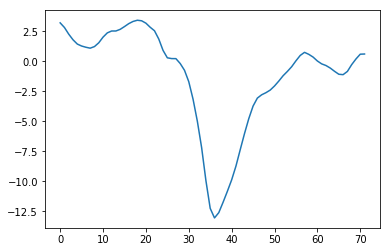

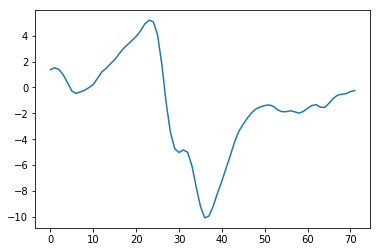

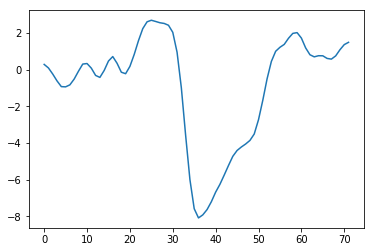

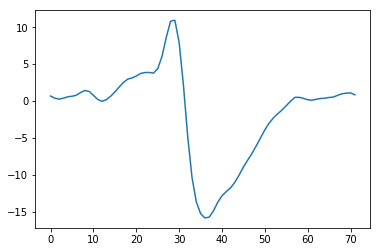

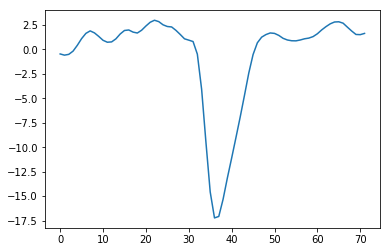

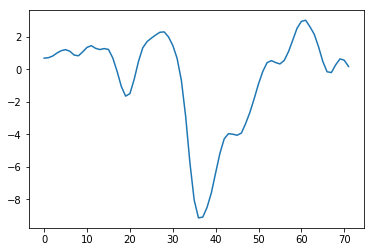

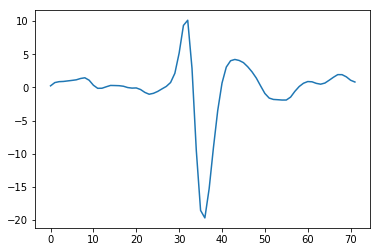

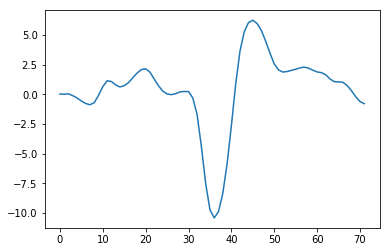

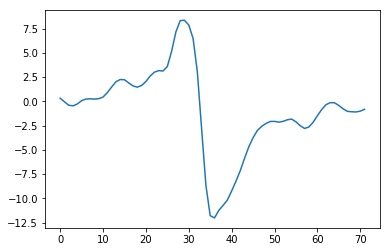

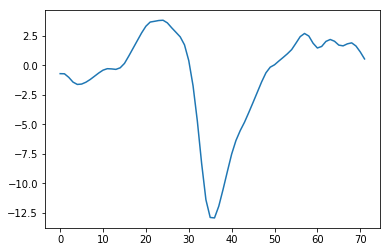

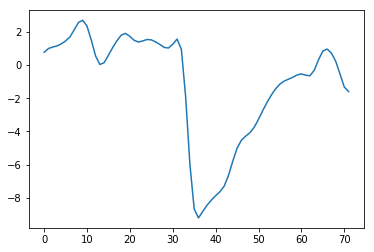

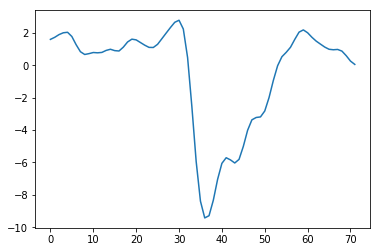

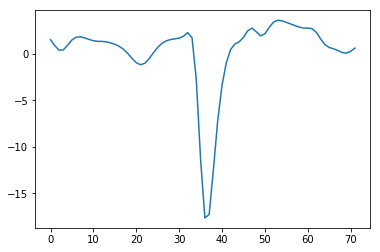

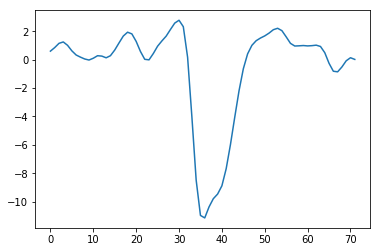

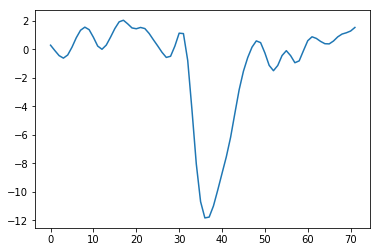

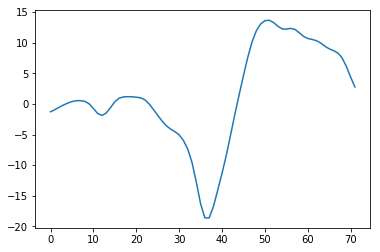

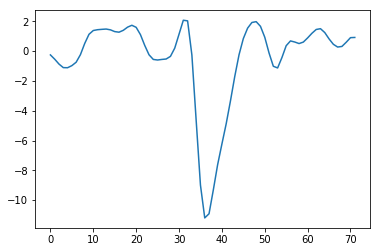

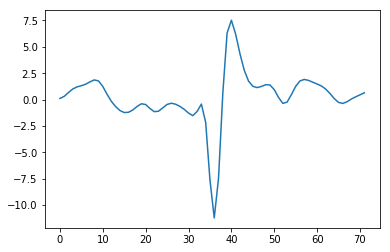

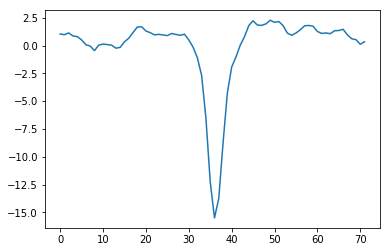

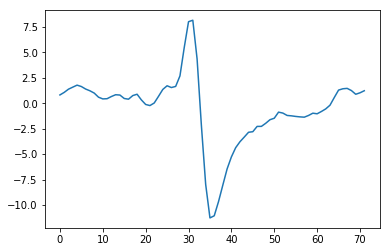

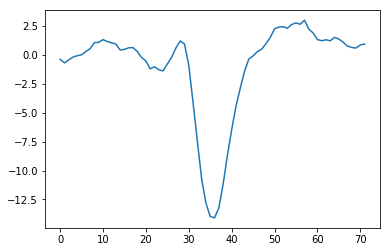

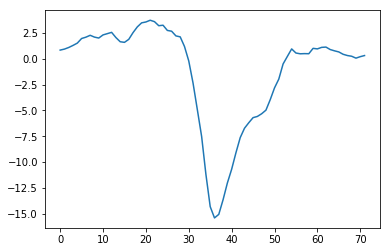

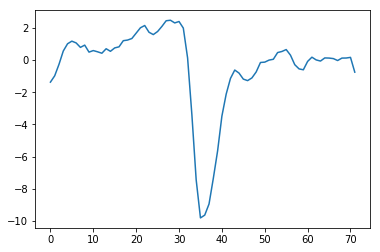

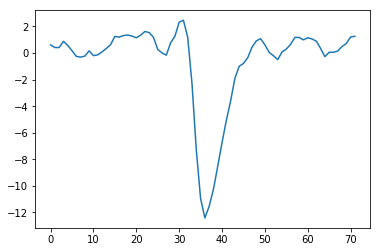

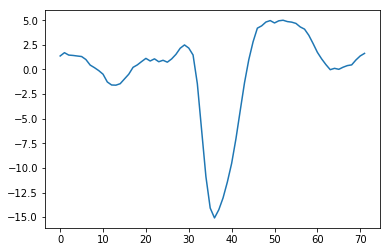

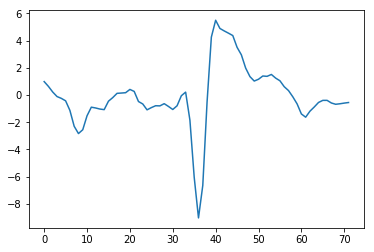

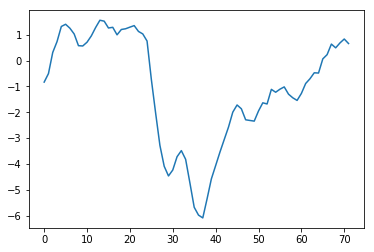

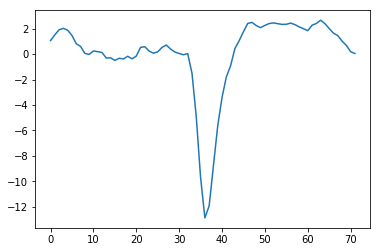

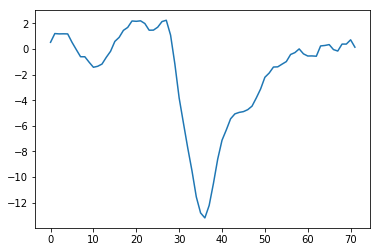

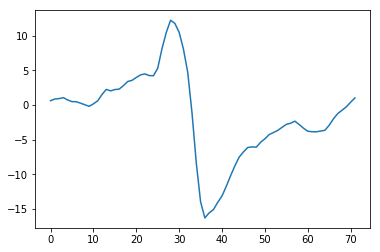

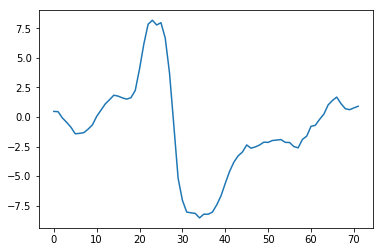

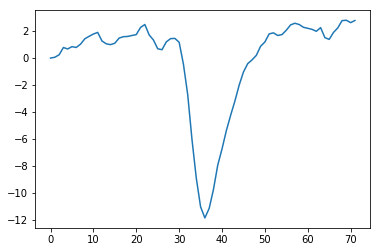

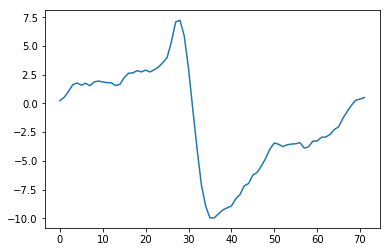

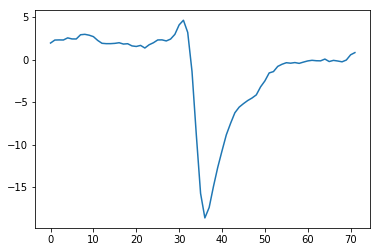

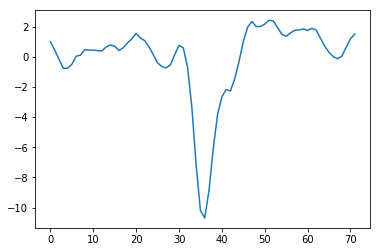

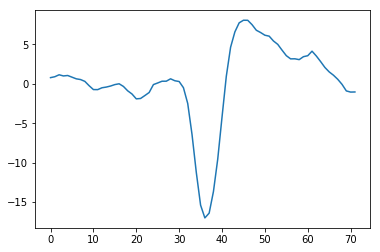

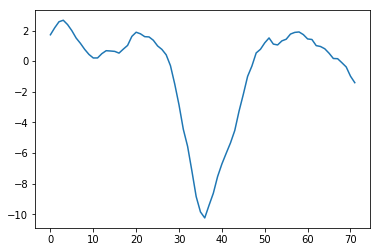

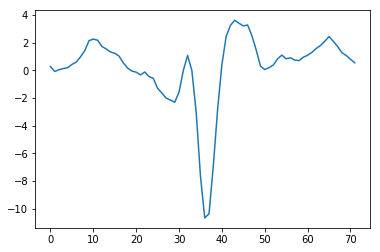

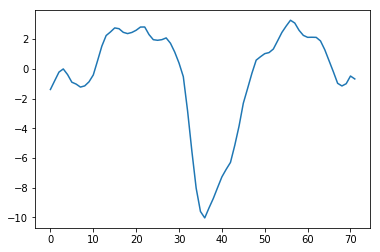

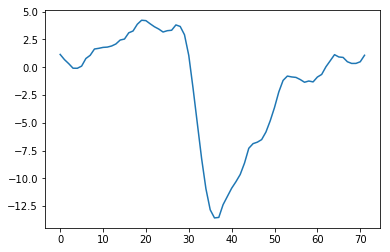

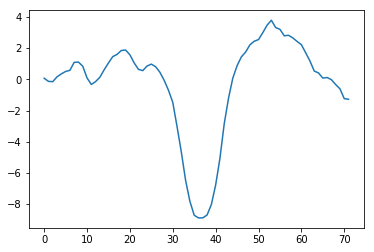

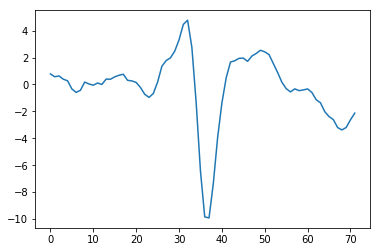

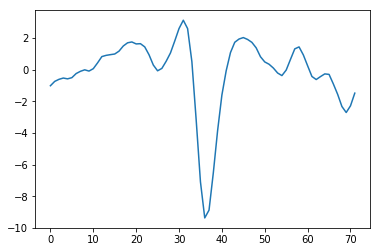

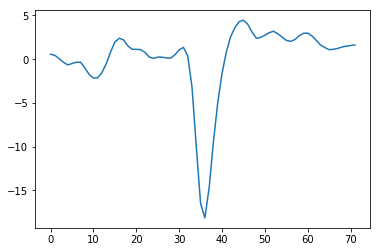

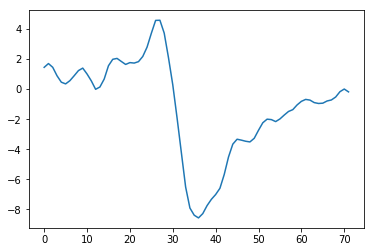

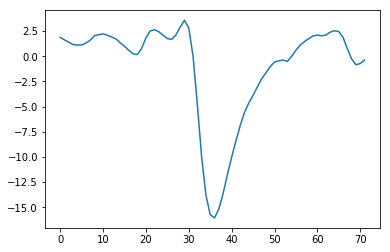

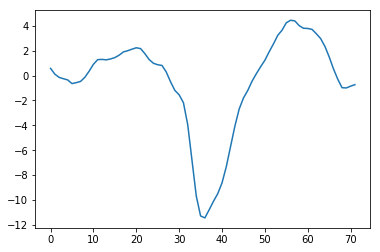

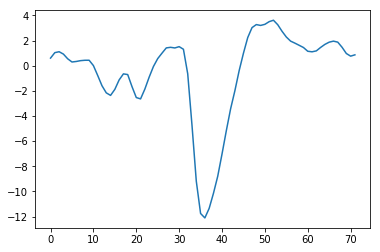

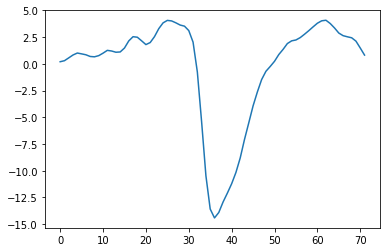

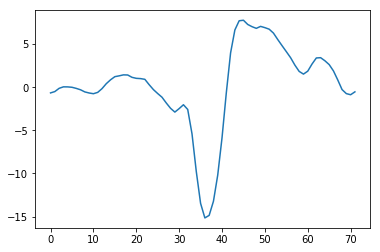

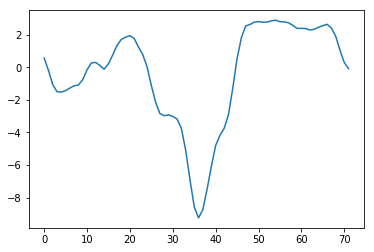

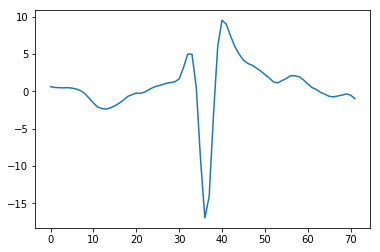

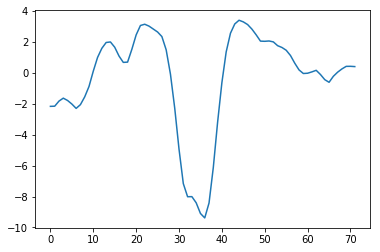

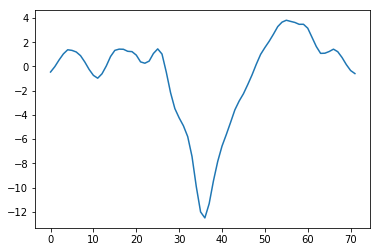

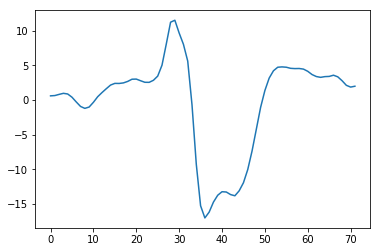

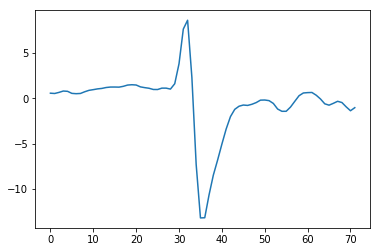

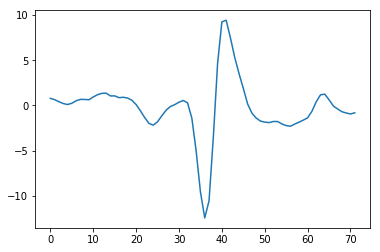

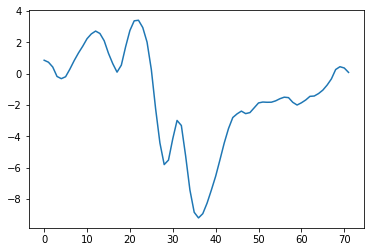

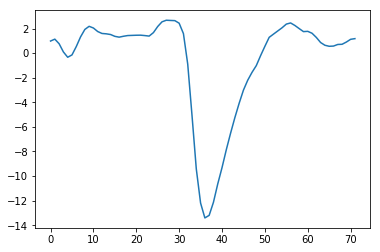

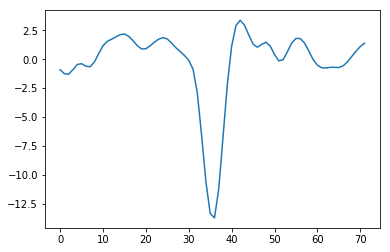

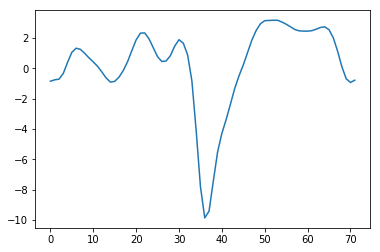

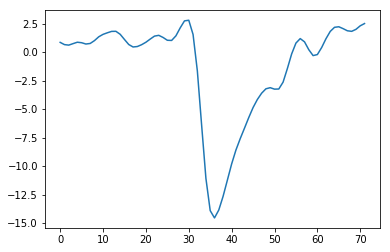

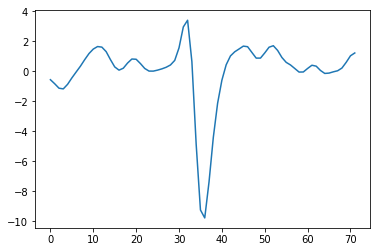

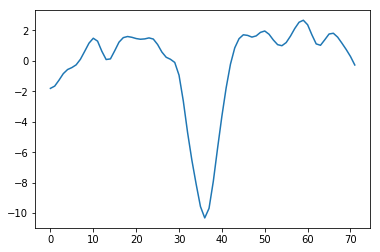

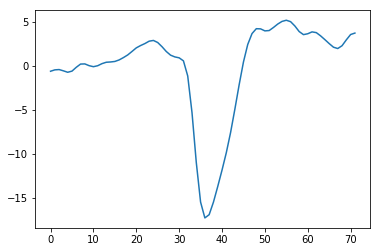

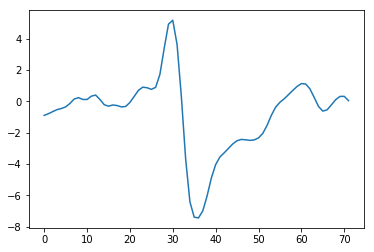

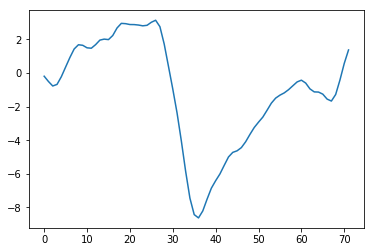

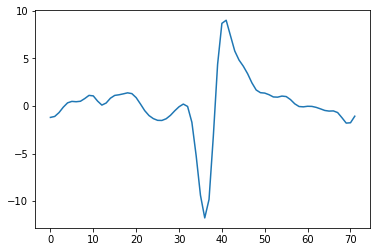

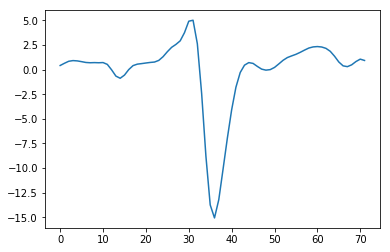

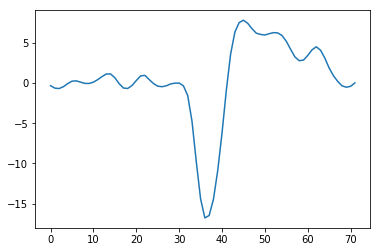

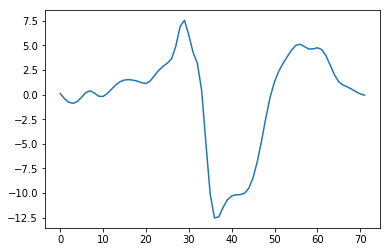

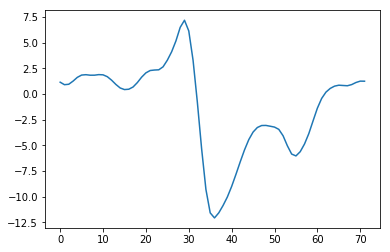

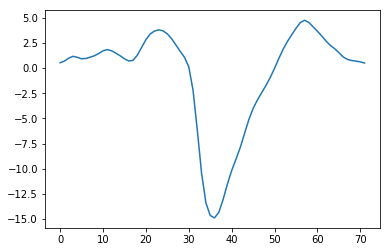

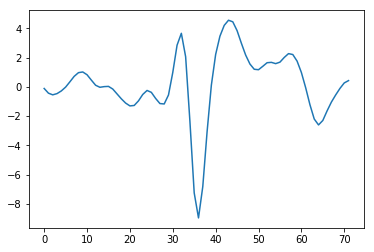

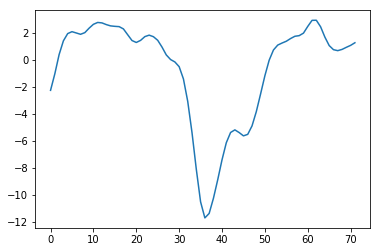

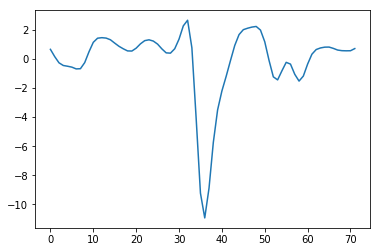

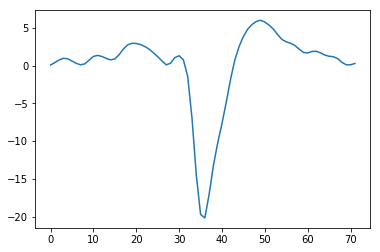

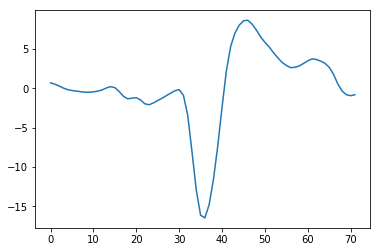

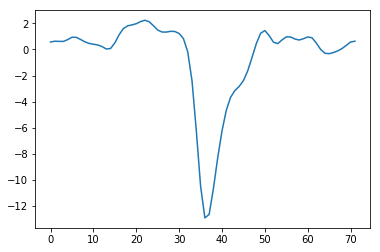

In [13]:
import matplotlib.pyplot as plt
counter = 0;
for i in range(10):
    for j in range(labels.size):
        if(labels[0, j] == counter):
            plt.figure(counter)
            plt.plot(dataset[j, :, :].ravel())
            counter = counter + 1;


In [17]:
np.save(path_to_train_data, dataset)
np.save(path_to_train_labels, labels)


In [15]:
mean = (np.mean(np_data_spikes))
std = (np.std(np_data_spikes))
np.save(path_to_mean_std, [mean, std])

print(mean)
print(std)

NameError: name 'np_data_spikes' is not defined